# Chapter 11: Credit Modeling
&copy; 2021 Kenneth Winston

Chapter 3 investigated the seeming impossibility of uncertainty arising from certainty: even when we know exactly when and how much money we will get in the future, the value we assign today to that future money can be highly variable.

The uncertainty doesn't stop there. "Fixed-income" (US usage) or "fixed-interest" (UK usage) securities are those for which the parties agree in advance on the schedule of future cash flows. But the "fixed" cash flows may be anything but certain. For example, there may be an arrangement where the amount of money to be exchanged is contingent on an interest rate that is unknown today, like the level of the Secured Overnight Financing Rate ([SOFR](https://apps.newyorkfed.org/markets/autorates/sofr)) at the time of the payment. Securities that make payments contingent on future benchmark interest rates are called **`floating rate`** instruments.

It's also possible that the uncertainty is unwanted. A borrower and a lender may agree on specific dollar amounts to be paid by the borrower in the future, but the borrower may be unable or unwilling to pay the agreed amounts. **`Credit risk`** is the uncertainty about whether or not a borrower will make agreed cash flows in the agreed amounts and/or at the agreed times.

In this chapter we'll discuss credit risk arising from corporate and sovereign borrowers. Lenders typically perform credit risk assessments themselves as they assemble credit portfolios, but they may also rely on information providers called credit rating agencies that provide scores to potential lenders. We'll discuss some of the qualitative and quantitative methods that lenders and credit rating agencies use.

## 11.1 Basic credit risk concepts ##

Chapter 3 noted that a generic financial instrument contemplates a series of cash flows $c_1,\dots,c_n$ at times $0\leq t_1,\dots,t_n$. Perhaps the simplest example of this is a default-free zero-coupon bond where there are two cash flows: one amount $c_1<0$ from the lender to the borrower at time $t_1=0$, and another one for a predetermined amount $c_2>0$ from the borrower to the lender at a predetermined time $t_2$ in the future.

To reflect the value now (time $t$) of cash flows $c_i$ at times $t_i$ in the future, Chapter 3 contemplated discount rates $r_i$ that would reflect current market views of what those future cash flows are worth today. We saw that those discount rates could be used to "bring back" the expected future cash flows to the present time $t$:
$$P_t=\sum_{i=1}^n\frac{\mathbb{E}[c_i]}{(1+r_{i,t})^{t_i-t}}\label{eq:discrete_discounting}\tag{11.1a}$$
$$P_t=\sum_{i=1}^n \mathbb{E}[c_i] exp(-r_{i,t} (t_i-t))\label{eq:continuous_discounting}\tag{11.1b}$$

The two formulas represent different discounting conventions. \eqref{eq:discrete_discounting} (which is the same as (3.2)) represents a discrete period discounting method, which is often close to what is used in practice. \eqref{eq:continuous_discounting} represents continuous compounding which often is easier than \eqref{eq:discrete_discounting} to manipulate in formulas. Recall from Section 3.2 that setting $r_{i,t}(b)=ln(1+r_{i,t}(a))$, often a very slight change, makes the two equal.

In Chapter 3, $\mathbb{E}[c_i]=c_i$, i.e. the planned cash flows were constants. But credit risk contemplates a stochastic **`time to default`** $t_d>0$: that is, a time, not currently known, at which the borrower becomes unable to fully pay scheduled cash flows $c_j,c_{j+1},\dots,c_n$[$^1$](#eleven_footnotes), where $j$ indexes the first $t_j\geq t_d$.

Post-default, the lender may receive nothing ($c_j=\dots=c_n=0$), although this is rare and usually occurs only in situations where the entire economic system has broken down.

More likely there is a **`recovery amount`** that is greater than zero but less than the scheduled amounts. **`Loss given default, LGD,`** is the complement of recovery: it is the difference between the amount scheduled to be received and the amount actually received. **`Severity`** is another term for LGD, although severity is often expressed in percentage terms while LGD is often expressed in monetary terms. **`Expected loss`** is the probability of default times the expected loss given default.

Credit-risky bonds understandably command lower prices than otherwise identical default-free bonds. A common way to account for this is to introduce a **`spread`** (denoted here by "s") into the discounting formula.
$$P_t^{CR}=\sum_{i=1}^n\frac{\mathbb{E}[c_i]}{(1+r_i+s)^{t_i-t}}\label{eq:discrete_credit}\tag{11.2a}$$
$$P_t^{CR}=\sum_{i=1}^n \mathbb{E}[c_i] exp(-(r_{i,t}+s) (t_i-t))\label{eq:continuous_credit}\tag{11.2b}$$

As in Chapter 3, the $r_{i,t}$ are based on some default-free curve, such as the US Treasury curve, the UK gilt curve, etc. Thus, these $r_{i,t}$ are the same as the ones used in \eqref{eq:discrete_discounting} and \eqref{eq:continuous_discounting} for default-free bonds.

But if the bond in question has credit risk (denoted by the superscript CR on the price), then $P_t^{CR}<P_t$, where $P_t$ is the price of an identical default-free bond. The default-free discount rates $r_{i,t}$ will not be big enough; the future cash flows of the credit-risky bond need to be discounted even more to bring the price down from $P_t$ to $P_t^{CR}$.

The additional discount amount $s$ is simply a plug number: it's the amount that makes the pricing equation (\eqref{eq:discrete_credit} or \eqref{eq:continuous_credit} depending on the discounting convention we want to use) come out right. Every other term is known: the price $P_t^{CR}$ is observed in the market, the default-free discount rates $r_{i,t}$ are observed from the market prices of default-free bonds; and the planned cash flows and times are specified in advance.

How big does $s$ have to be? That depends on (a) the market's assessment of the expected loss; (b) the market's risk appetite; and (c) other factors like taxes and liquidity. The expectation $\mathbb{E}[c_i]$ does not itself take into account default; it is the same time-$t$ expectation as if the bond were default-free. So item (a) is an adjustment for the lender's possible injury from default. But that possibility of default also makes the bond riskier, so $s$ will also contain item (b), compensation for that risk.

In theory, if the market thinks the bond is truly default-free, then we should see $s=0$. But in practice, the (c) "other" category can be quite significant. For example, corporate bonds are generally less liquid than major government bonds, so corporate spreads include some compensation for the perceived difficulty in buying or selling the instrument. Figure 11.4 below will show that historically a typical spread for very high credit quality corporate bond was on the order of $s=50$bps per year. Very little of this was compensation for loss given default.

As with many other pricing equations, \eqref{eq:discrete_credit} and \eqref{eq:continuous_credit} can be used as quoting conventions, where price can be found as a function of spread. Thus a credit-risky issuer's bond might be quoted as "200 over," meaning that a spread $s$ of 200 basis points over default-free discounting will give the market price when plugged into the appropriate pricing equation \eqref{eq:discrete_credit} or \eqref{eq:continuous_credit}.

## 11.2 Credit ratings ##

For centuries, lenders have tried to find out as much as possible about potential borrowers so that they (the lenders) can assess their chances of being repaid. Borrowers need to demonstrate to lenders that they (the borrowers) have a reasonable chance of repaying the money loaned to them, or they simply won't be able to borrow. Insisting that the borrower have a tenable fiscal position is the first line of defense against default for any lender.

Some lenders rely on personal knowledge. In the classic 1946 film [It's a Wonderful Life](https://www.imdb.com/title/tt0038650/plotsummary), George Bailey runs the Bailey Building and Loan company in the tiny town of Bedford Falls, where he personally knows every actual and potential borrower. While George has near-perfect information about his cohort of borrowers, he has no ability to expand and diversify his business by making loans outside his immediate community.

Making loans to strangers involves less information &mdash; which by definition means more risk &mdash; than making loans to family, friends and neighbors. On the other hand, making loans to strangers allows lenders to diversify and expand. Thus a key focus of economic history is the rise of information networks that supplied financial data and assessments of creditworthiness of businesses and individuals to potential lenders.

For example, Hoffman, Postel-Vinay, and Rosenthal[$^2$](#eleven_footnotes) found that starting in the seventeenth century a robust network of notaries public arranged transactions between French borrowers and lenders who didn't know each other. Hoffman et. al. highlight transactions between parties in the French province of Burgundy with parties in Lyon and Paris:
>For transactions to take place over such distances, lenders in large and distant cities such as Lyon or Paris had to believe that collateral pledges of Burgundian lands were valuable and plausible. That required information, and if intermediaries had not provided it, then the nobles in Burgundy could only have borrowed from other Burgundians... The implication is that our intermediaries &mdash; the notaries &mdash; furnished information services over a broad geographical area.

In this network the borrower and the lender didn't need to know each other directly, but personal knowledge was still important: a Burgundian borrower knew a Burgundian notary who knew a Parisian notary who knew a Parisian lender. 

Eventually such personal knowledge chains were dispensed with in favor of data, as computers and communications expanded to where vast amounts of information about individuals could be collected and analyzed. In 1958, engineer Bill Fair and mathematician Earl Isaac formed the [Fair, Isaac Company](https://www.fico.com/en/about-us#history). Currently called FICO, the company provides [FICO&reg; scores](https://www.myfico.com/credit-education/credit-scores) rating millions of potential individual borrowers looking for credit cards, mortgages, automobile loans, student loans, and the like. The consumers of these scores are generally financial institutions. More recently, fintech companies gather variables from borrowers' digital footprints, finding that they ["equal or exceed the information content of credit bureau scores."](https://www.fdic.gov/bank/analytical/cfr/2018/wp2018/cfr-wp2018-04.pdf)

In addition to services providing credit information and credit scores of individuals, services exist to supply this information about companies. One of the earliest such services in the US was the Mercantile Agency of the mid-1800s. This was a forerunner of [Dun & Bradstreet](https://www.dnb.com) which continues to offer corporate credit information to this day, like [this sample](https://www.dnb.com.lv/en/D&B-Sample.html). The [history section of the company's website](https://www.dnb.com/about-us/company/history.html) says:
>To help American merchants in their decision-making, an enterprising businessman named Lewis Tappan began, in 1841, to establish a network of correspondents that would function as a source of reliable, consistent and objective credit information. His Mercantile Agency, located in New York City, was one of the first organizations formed for the sole purpose of providing business information to customers.

The "network of correspondents" established by the Mercantile Agency in the mid-1800s was similar to the network of notaries public that Hoffman et. al. documented in 1600-1800s France. Over time, personal reporting gave way to the corporate information databases now in use.

Mercantile Agency (subsequently Dun & Bradstreet) ratings were applied to companies and were generally used by suppliers wanting to know their chances of getting paid. In the early 1900s, [John Moody](https://web.archive.org/web/20051103055906/http://www.moodys.com/moodys/cust/AboutMoodys/AboutMoodys.aspx?topic=history) 
adapted the application of credit rating systems to a new subject: corporate bonds. Moody eventually assigned letter grades to most corporate bonds in the US, from Aaa (meaning the highest credit quality with virtual certainty of repayment) down to D (meaning defaulted). Today [Moody's Corp.](https://www.moodys.com) is one of the largest bond rating services, rating a large portion of all bonds issued worldwide. These include the original corporate bonds as well as sovereign (government) bonds and structured credit, which we'll discuss below.

[Lawrence Wright](https://www.mercatus.org/publications/monetary-policy/brief-history-credit-rating-agencies-how-financial-regulation#end4) summarized the establishment of corporate bond credit rating agencies in the early twentieth century:
>Moody's firm was followed by Poor's Publishing Company in 1916, the Standard Statistics Company in 1922, and the Fitch Publishing Company in 1924. These firms sold their bond ratings to bond investors in thick rating manuals.

Poor's and Standard Statistcs eventually merged into Standard & Poor's, which continues to provide credit ratings today as part of S&P Global Corp. The "Big Three" credit rating agencies today consist of [Moody's](https://www.moodys.com), [Standard & Poor's](https://www.spglobal.com/ratings/en/about/index.aspx), and [Fitch](https://www.fitchratings.com): in 2011 they collectively comprised a market share of roughly 95% according to the German news service [Deutsche Welle](https://www.dw.com/en/sp-warning-puts-damper-on-eurogroup-plans/a-15212433).

The provision of credit rating opinions is considered as important to the smooth functioning of the economy as the provision of accounting audits. Just as accountants need to be certified by their local or national government, so too do credit rating agencies. In the US, the Securities & Exchange Commission maintains a list of [Nationally Recognized Statistical Ratings Organizations](https://www.sec.gov/ocr/ocr-learn-nrsros.html), or "NRSRO's." The list currently includes the Big Three and seven others.

In Europe, the European Securities and Markets Authority has a [registration and certification program](https://www.esma.europa.eu/supervision/credit-rating-agencies/supervision) for credit rating agencies. The [ESMA approved list](https://www.esma.europa.eu/supervision/credit-rating-agencies/risk), like the US list, includes the Big Three and others.

The Big Three have similar but not identical rating scales for long-term debt.  [Moodys' scale](https://www.moodys.com/sites/products/AboutMoodysRatingsAttachments/MoodysRatingSymbolsandDefinitions.pdf) has notches that look like Aaa, Aa1, Aa2, Aa3, A1, ..., Caa3, Ca, and C in descending order. [Standard & Poors' scale](https://www.standardandpoors.com%/en_US/web/guest/article/-/view/sourceId/504352) is very similar, but (along with Fitch) uses all capital letters and pluses and minuses. Thus Moody's rating Aa3 is similar to Standard & Poor's rating AA-. Moody's definitions of its major notches are quite qualitative:

Table 11.1 | Moody's qualitative rating descriptions
------------- | -------------
Moody's Rating Classification  | Explanation
Aaa  | Obligations rated Aaa are judged to be of the highest quality, subject to the lowest level of credit risk
Aa  | Obligations rated Aa are judged to be of high quality and are subject to very low credit risk
A  | Obligations rated A are judged to be upper-medium grade and are subject to  low credit risk
Baa  | Obligations rated Baa are judged to be medium-grade and subject to moderate credit risk and as such may possess certain speculative characteristics
Ba  | Obligations rated Ba are judged to be speculative and are subject to substantial credit risk
B  | Obligations rated B are considered speculative and are subject to high credit risk
Caa  | Obligations rated Caa are judged to be speculative of poor standing and are subject to very high credit risk
Ca  | Obligations rated Ca are highly speculative and are likely in, or very near, default, with some prospect of recovery of principal and interest
C  | Obligations rated C are the lowest rated and are typically in default, with little prospect of recovery of principal and interest

We'll examine historical data below that gives some specificity to terms like "highest quality."

Despite generally using the same financial data inputs and having similar ratings scales, credit rating agencies don't always agree with each other. Most famously, at this writing there is disagreement about the world's biggest borrower: of the Big Three, [Moody's](https://www.moodys.com/research/Moodys-affirms-United-States-Aaa-rating-maintains-stable-outlook--PR_382024) and [Fitch](https://www.fitchratings.com/site/pr/10103089) rate the US government Aaa (highest), while [Standard & Poor's](https://www.standardandpoors.com/en_US/web/guest/article/-/view/sourceId/6802837) rates it a notch below the highest rating at AA+.

### 11.2.1 Investment grade and speculative grade ###

Most credit rating agencies divide the bond market broadly into two quality levels:
- **`Investment Grade Bonds`** that are expected to have a very high chance of avoiding default; and
- **`Speculative Grade Bonds`** (also called **`High Yield Bonds`**) that have higher chances of default than investment grade bonds.

This bifurcation was a result of the New Deal legislation and regulations the US that followed the Great Depression. According to [Lawrence Wright](https://www.mercatus.org/publications/monetary-policy/brief-history-credit-rating-agencies-how-financial-regulation#end4), in 1936
>...the Office of the Comptroller of the Currency prohibited banks from investing in "speculative investment securities," as determined by "recognized rating manuals" (i.e., Moody's, Poor's, Standard, and Fitch). "Speculative" securities were bonds that were below "investment grade," thereby forcing banks that invested in bonds to hold only those bonds that were rated highly (e.g., BBB or better on the S&P scale) by these four agencies. In effect, regulators had endowed third-party safety judgments with the force of law.

>In the following decades, insurance regulators and then pension fund regulators followed with similar regulatory actions that forced their regulated financial institutions to heed the judgments of a handful of credit rating agencies.


### 11.2.2 Historical Default Frequencies ###

We've seen a number of qualitative phrases like a "very high chance of avoiding default" to describe investment grade bonds. But what do these terms mean in precise numbers?

Traditional rating agencies do not directly target a particular percentage chance of avoiding default. Instead they look at various factors comprising the legal and business environment and the company's fiscal health, such as these listed by [Standard & Poor's](https://www.standardandpoors.com/en_US/web/guest/article/-/view/sourceId/6485398):
- Creditworthiness Before External Support
 - Future income and cash flows
   - Sources (ongoing operations or investments)
   - Variability
 - Economic conditions
 - Regulatory environment
 - Economic projections and forecasts
 - Liquid assets
 - Accounting principles and practices
 - Key financial indicators
   - Profitability
   - Leverage
   - Cash flow adequacy
   - Liquidity
   - Financial flexibility
 - Trends over time
 - Peer comparisons
- External Influence
 - Likelihood and potential amount of external support
 - Existence of guarantee by higher-rated guarantor
 - Affiliated business entities
 - Negative influences, e.g. weaker parent draining cash flows or assets

These factors are then considered by analysts and discussed by a committee that issues a rating opinion.[$^3$](#eleven_footnotes)

While the rating agencies don't want to be pinned down to exact metrics, there are fairly reliable feature sets that separate ratings. Moody's periodically publishes key ratios by rating, such as the ones in Table 11.2:

Table 11.2 | Moody's Financial Metrics&trade key ratios by rating and industry for global nonfinancial corporates: 2020 Update. [Appendix A: median ratios](https://www.moodys.com/research/Corporates-Global-Moodys-Financial-Metrics-key-ratios-by-rating-and--PBC_1242809) |
------------- | ------------- |

| Item |&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Aaa|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Aa|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   A|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Baa|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   Ba|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   B|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Caa-C |
|:----|--------:|----:|----:|----:|-----:|-----:|------:|
| Debt/EBITDA  | $ 1.5$ | $ 1.2$ | $2.3$ | $2.9$ | $3.7$ | $5.9$ | $7.6$ |
| EBITDA/Interest Expense  | $20.4$ | $23.8$ | $11.8$ | $6.3$ | $3.8$ | $1.7$ | $0.7$ |
| Revenue  | $143.0$ | $71.0$ | $20.2$ | $8.2$ | $3.0$ | $0.9$ | $0.7$ |
| Retained Cash Flow/Net Debt  | $19.4\%$ | $31.2\%$ | $29.0\%$ | $23.5\%$ | $18.8\%$ | $8.1\%$ | $2.9\%$ |
| EBITDA Margin  | $30.3\%$ | $22.5\%$ | $14.8\%$ | $14.3\%$ | $13.5\%$ | $13.0\%$ | $7.4\%$ |
| Operating Margin  | $25.3\%$ | $18.4\%$ | $12.6\%$ | $12.2\%$ | $11.5\%$ | $8.4\%$ | $4.2\%$ |
| FFO/Debt  | $46.5\%$ | $61.0\%$ | $34.9\%$ | $27.9\%$ | $19.8\%$ | $8.8\%$ | $3.2\%$ |
| (FFO + IntExp) / IntExp  | $29.6$ | $26.1$ | $14.3$ | $8.4$ | $5.0$ | $2.4$ | $1.4$ |
| EBITA / Average Assets | $16.0\%$ | $13.9\%$ | $9.7\%$ | $7.8\%$ | $8.2\%$ | $6.6\%$ | $4.6\%$ |
| CAPEX / Depreciation | $1.3$ | $1.2$ | $1.3$ | $1.3$ | $1.2$ | $1.2$ | $0.9$ |
| Revenue Volatility | $11.9$ | $10.4$ | $10.2$ | $11.0$ | $14.4$ | $17.9$ | $13.4$ |

The reader doesn't need to be an accounting expert to see which metrics are desirable and which aren't: they are mostly monotone increasing or decreasing. The first item is the ratio of the company's debt to its earnings: EBITDA is "earnings before interest, taxes, depreciation, and amortization." It's intuitively clear that the lower the ratio of debt to earnings, the better chance a company will pay back its debt. This is borne out by the numbers, with a small inconsistency between Aaa and Aa.

These ratios, with minor adjustments, were as relevant one hundred years ago as they are today. Readers with data science backgrounds will realize that it would be easy to use a standard support-vector machine with features like those in Table 11.2 to assign credit ratings, or to predict directly the chance of default. We'll talk about methods based on that idea in Section 11.8 below.

The rating agency process produces ratings that tend to be reliably ordinal but not reliably cardinal. With a few small exceptions, the default rates of classifications higher up in Table 11.1 are lower than the default rates of inferior classifications.

But the actual level of defaults varies year by year depending on economic conditions. Figure 11.1, using data from *Moody's Annual Default Study: Corporate Default and Recovery Rates, 1920-2020, Exhibit 38*, shows the year-by-year default rates for investment grade bonds (left axis, blue) and speculative grade bonds (right axis, red) since 1920:

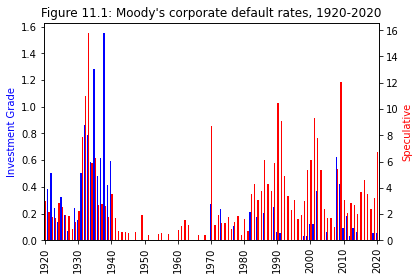

Investment grade:
    Min:  0.0
    Avg: 0.142. Since 1981: 0.083
    Max:  1.5503839897212046  Year:  1938
    Percentage of years with no defaults:  56.43564356435643
Speculative:
    Min:  0.0
    Avg: 2.858. Since 1981: 4.252
    Max:  15.76957171295379  Year:  1933
    Percentage of years with no defaults:  11.881188118811881


In [3]:
#Display bar charts with investment grade and speculative
#grade defaults year by year
#Data from Moody's Corporate Default and Recovery Rates,
#1920-2020, Exhibit 38
#Original file
#https://www.moodys.com/research/
#Annual-default-study-Following-a-sharp-rise-in-2020-corporate--PBC_1263901
#Needs a Moodys login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filename = "Default Reports - Annual-default-study-Following-a-sharp-" \
    + "rise-in-2020-corporate-defaults-will-... - 26Feb21.xlsx"

default_rates = pd.read_excel(filename, sheet_name='Ex38', skiprows=2, engine="openpyxl")
default_rates.rename(columns={default_rates.columns[0] : 'Year'},inplace=True)

#Find number of actual years
n_years=default_rates.loc[default_rates['Year']=='Mean'].index.values[0]
#Lop off the summary information after years
default_rates.drop(np.arange(n_years,len(default_rates)),inplace=True)
#Change scale so that 1=1%
default_rates.IG=default_rates.IG.mul(100.)
default_rates.SG=default_rates.SG.mul(100.)

fig=plt.figure() # Create matplotlib figure

#Set up two axes because of different orders of
#magnitude between IG and HY
ax = fig.add_subplot(111)
ax2 = ax.twinx() # Create another axis that shares the same x-axis as ax.

width = 0.4

default_rates.IG.plot(kind='bar', color='blue', ax=ax, width=width, position=1)
default_rates.SG.plot(kind='bar', color='red', ax=ax2, width=width, position=0)

ax.set_ylabel('Investment Grade', color='blue')
ax2.set_ylabel('Speculative', color='red')

stride=10
plt.xticks(range(0,n_years,stride),default_rates["Year"].iloc[::stride],rotation=45)

plt.title("Figure 11.1: Moody's corporate default rates, 1920-" \
          +str(default_rates['Year'].iloc[n_years-1]))
plt.show();

#Show averages, mins, maxes
print('Investment grade:')
print('    Min: ',min(default_rates.IG))
print('    Avg: %1.3f' % np.average(default_rates.IG) + ". Since 1981: %1.3f" \
    % default_rates[default_rates.Year>=1981].IG.mean())
print('    Max: ',max(default_rates.IG)," Year: ", \
      list(default_rates.loc[default_rates.IG==max(default_rates.IG)].Year)[0])
print('    Percentage of years with no defaults: ', \
      default_rates.IG.value_counts().iloc[0]*100./len(default_rates.IG))
print('Speculative:')
print('    Min: ',min(default_rates.SG))
print('    Avg: %1.3f' % np.average(default_rates.SG)+". Since 1981: %1.3f" \
      % default_rates[default_rates.Year>=1981].SG.mean())
print('    Max: ',max(default_rates.SG)," Year: ", \
      list(default_rates.loc[default_rates.SG==max(default_rates.SG)].Year)[0])
print('    Percentage of years with no defaults: ', \
      default_rates.SG.value_counts().iloc[0]*100./len(default_rates.SG))

The average default rate of investment grade ("IG") bonds was a fraction of a percentage point per year, while the average default rate of speculative grade bonds was less than $3\%$ per year. For IG bonds the worst default rate in the last century was $1.55\%$ in 1938. Thus IG defaults, even in the Great Depression, were relatively rare. It is apparent from the chart above that the IG median and mode default rates are both zero. That's why we had to use a different scale for IG (left) as opposed to speculative (right); the IG defaults would barely have been visible otherwise.

As we saw above, the rating agencies look largely to time-invariant quantities such as leverage (the ratio of enterprise value to equity) to set the ratings. An enterprise that is largely funded through debt is probably going to have a higher chance of default on that debt than an enterprise that is largely funded through equity. That leads to the ordinal reliability that we noted above.

But it's clear from the historical record that the chance of default varies widely over time. $15.77\%$ of speculative bonds defaulted in 1933; none in 1946. Thus the cardinal meaning of credit ratings needs to be understood in context. In a low-volatility market, the chance of a move in asset value down to the point of default is lower than the chance of a move to default in a high-volatility market.

While Figure 11.1 shows that investment grade defaults are rare, it doesn't take into account **`ratings migration`**. An investment grade company that gets into financial trouble might see its bonds become **`fallen angels`**, i.e bonds that are downgraded to speculative grade although they haven't (yet) defaulted. Sometimes these bonds recover and become **`rising stars`**, bonds that were speculative grade but that have been upgraded to investment grade. However if instead the financial deterioration continues, the bonds may default. In this case, their last rating before default was speculative.

The ratings migration process may take years, so it may be that a bond that is currently rated (say) AA will default ten years from now after migrating down to (say) single-B. The large credit rating agencies track historical cumulative probabilities of default by year after a bond has a particular rating. Table 11.3 shows Standard & Poor's default rates by rating notch and year:

Table 11.3 | [S&P Table 24: Global Corporate Average Default Rates (1981-2020)](https://www.spglobal.com/ratings/en/research/articles/210407-default-transition-and-recovery-2020-annual-global-corporate-default-and-rating-transition-study-11900573) |
------------- | ------------- |

| Yr |  AAA |  AA  |   A  |  BBB |   BB  |   B   | CCC/CC |  IG  |   SG  |  All  |
|----|:----:|:----:|:----:|:----:|:-----:|:-----:|:------:|:----:|:-----:|:-----:|
| 1  | 0.00 | 0.02 | 0.05 | 0.16 | 0.63  | 3.34  | 28.30  | 0.09 | 3.71  | 1.53  |
| 2  | 0.03 | 0.06 | 0.13 | 0.43 | 1.93  | 7.80  | 38.33  | 0.24 | 7.19  | 3.00  |
| 3  | 0.13 | 0.11 | 0.22 | 0.75 | 3.46  | 11.75 | 43.42  | 0.41 | 10.18  | 4.27  |
| 4  | 0.24 | 0.21 | 0.33 | 1.14 | 4.99  | 14.89 | 46.36  | 0.63 | 12.63 | 5.35  |
| 5  | 0.34 | 0.30 | 0.46 | 1.54 | 6.43  | 17.35 | 48.58  | 0.86 | 14.64 | 6.25  |
| 6  | 0.45 | 0.41 | 0.60 | 1.94 | 7.75  | 19.36 | 49.61  | 1.09 | 16.30 | 7.01  |
| 7  | 0.51 | 0.49 | 0.76 | 2.27 | 8.89  | 20.99 | 50.75  | 1.30 | 17.68 | 7.64  |
| 8  | 0.59 | 0.56 | 0.90 | 2.61 | 9.90 | 22.31 | 51.49  | 1.50 | 18.83 | 8.18  |
| 9  | 0.64 | 0.63 | 1.05 | 2.93 | 10.82 | 23.50 | 52.16  | 1.69 | 19.86 | 8.67  |
| 10 | 0.70 | 0.70 | 1.20 | 3.24 | 11.64 | 24.62 | 52.76  | 1.88 | 20.81 | 9.12  |
| 11 | 0.72 | 0.76 | 1.34 | 3.55 | 12.33 | 25.58 | 53.21  | 2.05 | 21.61 | 9.50  |
| 12 | 0.75 | 0.82 | 1.46 | 3.80 | 12.99 | 26.31 | 53.68  | 2.20 | 22.29 | 9.83  |
| 13 | 0.78 | 0.88 | 1.59 | 4.03 | 13.59 | 26.99 | 54.23  | 2.35 | 22.93 | 10.13 |
| 14 | 0.84 | 0.93 | 1.71 | 4.28 | 14.09 | 27.63 | 54.69  | 2.49 | 23.49 | 10.41 |
| 15 | 0.90 | 0.99 | 1.84 | 4.54 | 14.65 | 28.24 | 54.76  | 2.65 | 24.04 | 10.69 |

For example, a very small fraction of AAA bonds defaulted two years after being rated AAA. Since no bonds defaulted within one year of being rated AAA, there must have been down-migrations in ratings for the tiny fraction that did default after two years.

Table 11.3 also confirms that the ordinal property virtually always holds for credit ratings: as we read across the rows of the table, default frequencies go up as the notches go down in quality. There are a few small exceptions (on the order of basis points) between AAA and AA, but otherwise the order is as expected.

Table 11.3 comes from Standard & Poor's, while Figure 11.1 comes from Moody's. But the orders of magnitude of default frequencies are similar: restricting the Moody's data to the same time period (1981 on) as the Standard & Poor's data, the one-year investment grade average default rate was virtually the same as the figure in Table 11.3. The corresponding one-year default rates for speculative grade were a little further apart, with Moody's higher than Standard & Poor's.

Thus while Moody's and Standard and Poor's target relative rankings in their ratings processes as shown in Table 11.1, over long periods they seem to come up with similar levels of cardinal credit ratings (i.e. levels of defaults). 

There are methods that directly target default levels using algorithms intended to find a firm's **`expected default frequency (EDF)`** given its financial condition and other inputs. These methods are usually based on the Merton structural model that we first saw in Chapter 9. For example, Barclays Bank developed a Corporate Default Probability Model that directly estimated default probabilities. Figure 11.2 shows the Barclays model estimated probabilities compared to Moody's historical frequencies on a log-scale:

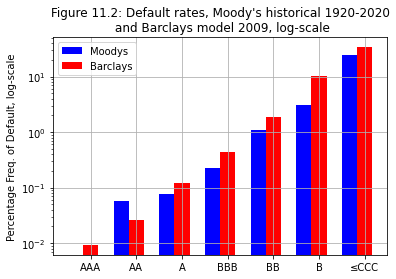

In [4]:
#Data from Moody's Corporate Default and Recovery Rates,
#1920-2020 Exhibit 33 (1-year) and Barclays Capital,
#“The Corporate Default Probability Model,” April 2009
ratings=['AAA','AA','A','BBB','BB','B','≤CCC']
edf2009=[.0093,.0264,.1198,.4393,1.852,10.22,33.904]
indices = [1,2,3,4,5,6,7]
#Calculate optimal width
width = np.min(np.diff(indices))/3

filename = "Default Reports - Annual-default-study-Following-a-sharp-" \
    + "rise-in-2020-corporate-defaults-will-... - 26Feb21.xlsx"

migrations=pd.read_excel(filename, sheet_name='Ex33', engine = "openpyxl")
date_range=migrations.columns[0][-9:]
#Last column gives migrations to default over one year
moodys=[migrations.iloc[2][-1],migrations.iloc[3][-1],migrations.iloc[4][-1], \
        migrations.iloc[5][-1],migrations.iloc[6][-1],migrations.iloc[7][-1], \
        migrations.iloc[9][-1]]
moodys=np.multiply(moodys,100.)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width,moodys,width,color='b',label='Moodys')
ax.bar(indices,edf2009,width,color='r',label='Barclays')
plt.grid()
plt.xticks(indices,ratings)
plt.yscale('log')
plt.ylabel('Percentage Freq. of Default, log-scale')
plt.legend()
str_title="Figure 11.2: Default rates, Moody's historical "+ date_range
str_title+="\n and Barclays model 2009, log-scale"
plt.title(str_title)
plt.show()

The Barclays estimates were made in 2009 at the height of the Global Financial Crisis, so they are understandably higher than the long-term Moody's frequencies. But the orders and shapes are similar. Both methods produce something that looks like a straight line on a log-scale, which means that default probabilities/frequencies increase exponentially as ratings go down. For the Barclays estimates, the ratings were not an input but rather were used to group the bonds after the estimates were made.

### 11.2.3 Sovereign Debt Ratings ###

Credit ratings are also applied to sovereign (government) bonds, including national governments and local authorities like states, provinces, cities, and government agencies like the [Port Authority of New York and New Jersey](https://corpinfo.panynj.gov/pages/consolidated-bonds-notes/) or [Eksportfinans ASA](https://www.eksportfinans.com/).

There is a saying that "corporations default because they have to; sovereigns default because they want to." This is an exaggeration, but sovereigns may have options that corporations don't:
- Sovereigns can raise taxes or tolls on their subjects
- Sovereigns can nationalize private property by law or by force &mdash; an extreme form of taxation
- Conversely, sovereigns can privatize or franchise public property (e.g. airports, bridges, roads), realizing revenues and fees
- If a sovereign controls the central bank that regulates the supply of the currency in which the debt is to be repaid, it can create more money and pay back its debt in devalued currency
- Sovereigns can choose to abrogate other obligations like payments to retired workers

For a corporation, default is an existential choice: after default a corporation may cease to exist altogether; at the very least it will be significantly restructured. So corporations generally default when they just can't pay their debts.

But sovereigns may have a choice as to how much pain they want to inflict on their citizens using the options above. Sovereigns also don't face the existential threat from default that corporations do: the sovereign will continue to exist after default. It may find some of its assets seized in partial payment of the debt, and it may very well find that it can't borrow again for quite a while after default. But a sovereign won't perish simply due to default.

In fact even financial punishments for sovereign default &mdash; like inability to borrow further &mdash; are uncertain. Consider Argentina's debt history in Table 11.4:

Table 11.4 | Argentina Debt History[$^4$](#eleven_footnotes)
------------- | -------------
<u>Year  | <u>Event
1816  | Argentina declares independence from Spain
1827  | Defaults on debt because Bank of England hiked interest rates
1890  | Default; contributed to Bank of England need to rescue House of Baring
1951  | Default
1956  | Restructuring; military coup
1982  | Default
1989  | Default; general emerging market debt crisis
2001  | Default; unsustainable heavy borrowing during 1990s
2014  | Default
2017  | Sells 100-year bond that is 4x oversubscribed
2019  | Begins restructuring "massive" debt in August. Defaults again in December. Gets IMF bailout
2020  | Misses interest payment of $\$500$ million; negotiates writedown in debt of $\$66$ billion

After becoming a nation in 1816 and fighting a war of independence, Argentina was able to borrow from international banks largely based in London. By 1827, however, as part of a general crisis in Latin American debt, Argentina defaulted. Understandably, international lenders would not loan money to Argentina for decades after that.
    
But fifty years after the 1826 default, Argentina had a completely different government and a completely different economy. So it's also understandable that foreign lenders would feel that they could return. In particular, the British House of Baring was heavily involved in loans to Argentina when Argentina defaulted again in 1890. Argentina's default would have led to Barings' default but for a rescue operation by the Bank of England.[$^5$](#eleven_footnotes)
    
Again, it's understandable that Argentina was not able to borrow for quite a while after the 1890 default. But by the mid-1900s it built up debt as, once again, lenders could reason that there was a completely different government and a completely different economy than the one that defaulted so long ago in 1890.

The next default was in 1951. Using the reasoning outlined above, Argentina should have been unable to borrow for a number of decades as international lenders penalized the country and waited for a complete change in people, government and economy.

But Table 11.4 shows a pattern of rapid-fire defaults, in some cases only a few years apart, after the 1951 default. Argentina was even able to sell a "century bond" &mdash; a bond not requiring repayment of principal for 100 years &mdash; three years after its 2014 default. Two years after that, Argentina restructured its debt again.

Why would any lender trust a country with a long history of defaulting on debt, and with a fresh default in the recent past? Part of the answer to that question is in the satirical title of the paper (later a book) by Carmen Reinhart and Kenneth Rogoff: *This Time is Different: A Panoramic View of Eight Centuries of Financial Crises.* Financial actors convince themselves that *this time is different* even though it isn't. Noting in 2017 that investors were rushing to buy Argentina's 100-year bond, a [Financial Times](https://www.ft.com/content/5ac33abc-551b-11e7-9fed-c19e2700005f) article contained this quote:
>[The Argentines] "cured" the latest default in 2016, and times have changed, said Joe Harper, a partner at Explorador Capital Management, an investment fund focused on Latin America. "The policy pendulum in Argentina has shifted to the centre, and the country's next 100 years will be very different than the last century." 

Two years into the "very different" century after 2017, there was a new government and a new debt restructuring in Argentina.

Witty credit market participants have characterized restructuring as "amend, extend and pretend." This means that when a debtor cannot pay, the lenders amend the debt agreements, extend the time allowed to repay, and pretend that these measures will somehow allow them eventually to recover their principal and interest. 
    
Another, more hard-headed, rationale for lending to a serial defaulter is that a bond's default does not necessarily mean that investing in that bond was a bad idea. Argentina's 100-year bonds paid almost $8\%$ a year. At the time that was about $5.1\%$ a year higher than the US Treasury long-term rate. An investor might have no illusions about Argentina's ability to last 100 years without defaulting. But an investor might more realistically think that the next default would be at least 20 years in the future. By that time, given the high coupon on the bonds, the investor would have recovered principal and made some profit. Further, a keen-eyed investor might note that there is often some partial recovery of principal in default or restructuring. So with a high coupon, some recovery, and a sufficiently long time to default, an investor might expect to turn a nice profit even with a default.

And that was just the downside scenario. There was also an upside scenario where, at least for a while, Argentina's fiscal picture improved and the $5.1\%$ spread over US Treasurys tightened by (say) $2\%$, leading to a rapid double-digit percentage increase in the price of the bonds.

With the benefit of hindsight, we can see that the upside didn't happen, nor did the default scenario take a comfortably long time to play out. But it was not completely illogical in 2017 to expect that it might be longer than two years until Argentina's next default.

There seems to be an offset between the many options that sovereigns have that corporations don't (which would tend to lower sovereign defaults) and the relatively mild punishment for sovereign default compared to corporate default (which would tend to increase sovereign defaults). Sovereigns rated AAA and AA have used the tools available to them to prioritize maintaining their high ratings and relatively low borrowing costs: Table 11.5 below shows they had no defaults at all over the subsequent $15$ years.

But as ratings got lower, the frequency of sovereign default in Table 11.5 compared to corporate default in Table 11.3 got higher. After two years a CCC or below sovereign was more likely than not to default. However the overall IG and SG default frequencies for sovereigns were quite similar to the overall IG and SG default frequencies for corporates. This was due to different mixes of ratings within those categories.

Table 11.5 | [S&P Table 17: Sovereign Foreign Currency Cumulative Average Default Rates Without Rating Modifiers (1975-2020)](https://www.spglobal.com/ratings/en/research/articles/210412-default-transition-and-recovery-2020-annual-sovereign-default-and-rating-transition-study-11888070) |
------------- | ------------- |

| Yr |  AAA |  AA  |   A  |  BBB |   BB  |   B   | CCC/CC |  IG  |   SG  |  All  |
|----|:----:|:----:|:----:|:----:|:-----:|:-----:|:------:|:----:|:-----:|:-----:|
| 1  | 0.0  | 0.0  | 0.0  | 0.0  | 0.4   | 2.6   | 46.5   | 0.0  | 3.3   | 1.2   |
| 2  | 0.0  | 0.0  | 0.0  | 0.4  | 1.4   | 6.6   | 54.2   | 0.1  | 6.1   | 2.3   |
| 3  | 0.0  | 0.0  | 0.3  | 1.2  | 2.1   | 10.3  | 62.2   | 0.3  | 8.6   | 3.4   |
| 4  | 0.0  | 0.0  | 0.8  | 1.7  | 2.7   | 13.7  | 65.7   | 0.6  | 4.3   | 4.3   |
| 5  | 0.0  | 0.0  | 1.3  | 2.2  | 4.1   | 16.7  | 69.1   | 0.8  | 5.3   | 5.3   |
| 6  | 0.0  | 0.0  | 1.9  | 2.8  | 5.6   | 19.2  | 76.8   | 1.1  | 6.2   | 6.2   |
| 7  | 0.0  | 0.0  | 2.5  | 3.4  | 7.2   | 21.9  | 80.7   | 1.3  | 17.3  | 7.2   |
| 8  | 0.0  | 0.0  | 3.1  | 3.7  | 9.1   | 24.6  | 80.7   | 1.5  | 19.5  | 8.1   |
| 9  | 0.0  | 0.0  | 3.8  | 4.1  | 10.6  | 26.6  | 80.7   | 1.7  | 21.2  | 8.8   |
| 10 | 0.0  | 0.0  | 4.4  | 4.5  | 11.5  | 28.5  | 80.7   | 2.0  | 22.6  | 9.4   |
| 11 | 0.0  | 0.0  | 5.2  | 4.9  | 12.2  | 30.6  | 84.6   | 2.2  | 24.1  | 10.0  |
| 12 | 0.0  | 0.0  | 6.0  | 5.4  | 12.9  | 32.6  | 84.6   | 2.5  | 25.3  | 10.6  |
| 13 | 0.0  | 0.0  | 6.8  | 5.9  | 13.7  | 34.0  | 84.6   | 2.8  | 26.4  | 11.1  |
| 14 | 0.0  | 0.0  | 7.3  | 6.9  | 14.6  | 35.5  | 84.6   | 3.0  | 27.5  | 11.7  |
| 15 | 0.0  | 0.0  | 8.4  | 7.5  | 15.1  | 37.3  | 84.6   | 3.4  | 28.5  | 12.2  |
    

### 11.2.4 Sovereign spreads in the Eurozone ###

The [Eurozone or euro area](https://ec.europa.eu/info/business-economy-euro/euro-area/what-euro-area_en) consists of the member states of the [European Union](https://europa.eu/european-union/about-eu/eu-in-brief_en) that have adopted the euro as their currency. At this writing there are 19 countries that use the common currency.

There is a single monetary policy for the entire Eurozone, run by the [European Central Bank](https://www.ecb.europa.eu/home/html/index.en.html). Thus a Greek citizen can spend her euros in Germany, or France, or Greece without any conversion needed. But there are 19 different fiscal policies: each country decides how much to tax and spend. Each country also borrows money separately. Naturally, relatively higher-spending countries are considered less likely to repay their debt.

Germany is considered to have the strongest fiscal position in the European Union. (Norway is in Europe and is considered by some to have an even stronger fiscal position than Germany, but Norway is not a member of the European Union.) Bonds issued by the German government are considered to be the default-free references from which discount rates are formed for euro-denominated cash flows.

Other Eurozone countries' bonds have higher yields than Germany, reflecting less confidence in their ability to repay their debts. The **`sovereign spreads`** over Germany range from a little (France) to a lot (Greece). In general, sovereign spreads are like the credit spreads in \eqref{eq:discrete_credit} and \eqref{eq:continuous_credit} and arise when a sovereign issues debt in a currency that its government does not control.

Figure 11.3 shows historical sovereign spreads of three Eurozone countries over Germany. The [European debt crisis](https://www.cfr.org/backgrounder/eurozone-crisis) starting in 2009 is apparent in the alpine prominences on the graph. Greece, Ireland and Portugal all took bailouts from the "Troika" of international institutions comprised of the [European Commission](https://ec.europa.eu/info/index_en), the European Central Bank, and the [International Monetary Fund](https://www.imf.org/external/index.htm). While Portuguese and Irish debt was fully repaid with the help of the bailout, private Greek bondholders were forced to take a "voluntary" $50\%$ reduction in their principal amount. The difference between a voluntary reduction and a default is measured in lawsuits rather than in euros.

More recently, European sovereign spreads have abated to non-crisis levels. France and Portugal have spreads over Germany that are tighter than AAA corporate bonds (see Figure 11.4 below). Greece's spread over Germany is similar to a BBB corporate bond.

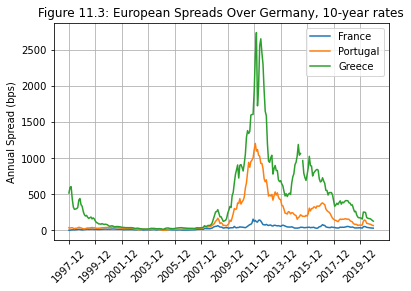

Ending values (2020-12-31) of spreads over Germany in bps/year
France  28.3
Portugal  64.9
Greece  124.8


In [5]:
%matplotlib inline
import qrpm_funcs as qf
import matplotlib.pyplot as plt
#Get European rates - show spreads

lastday=qf.LastYearEnd()

seriesnames=['IRLTLT01DEM156N','IRLTLT01FRM156N','IRLTLT01PTM156N','IRLTLT01GRM156N']
shortnames=['France','Portugal','Greece']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate='1997-12-31',enddate=lastday)
nobs=len(cdates)
x=range(nobs)
for i in range(len(shortnames)):
    plt.plot(x,[(y[i+1]-y[0])*100 for y in ratematrix],label=shortnames[i])

plt.ylabel("Annual Spread (bps)")
stride=24
plt.xticks(range(0,nobs,stride),[dt[:7] for dt in cdates[::stride]],rotation=45)
plt.legend()
plt.grid()
plt.title("Figure 11.3: European Spreads Over Germany, 10-year rates")
plt.show();

print("Ending values ("+lastday+") of spreads over Germany in bps/year")
for i in range(len(shortnames)):
    diff=np.multiply(ratematrix[-1][i+1]-ratematrix[-1][0],100.)
    print(shortnames[i]," %4.1f" % diff)

## 11.3 The Credit Spread Premium Puzzle ##
<a name="spread_premium_puzzle"></a>

When corporate bonds did default in the period 1983-2020, recovery rates given default ("RGD"s) averaged approximately 45% for investment grade bonds and 38% for speculative grade bonds.[$^6$](#eleven_footnotes) A rough calculation of the average loss rate for investment grade bonds is therefore 0.083% (the average rate since 1981 computed just after Figure 11.1) times (100%-45%), or 5bps a year. 

Due to the nature of averaging that rough calculation is not quite right. Fortunately Moody's calculated loss rates directly for the period 1983-2020. The five-year loss rate for investment grade bonds was $0.54\%$, or about $10$bps per year.[$^7$](#eleven_footnotes) Most of these losses occurred in "fallen angels," i.e. in bonds that started out as investment grade but were downgraded to speculative grade over the five year calculation window.

The $99.917\%$ of non-defaulting investment grade bonds would therefore need to yield $5-10$ bps more than US Treasurys to make up for the defaulting bonds. In fact investors receive far more than $5-10$ bps extra yield over Treasurys on investment grade bonds.

Figure 11.4 shows the extra yield (over comparable Treasurys) received by investment-grade corporate bonds: the lower line is for the highest-rated investment-grade bonds (Aaa Moody's=AAA S&P), while the higher line shows the extra yield received for the lowest-rated investment grade corporate bonds (Baa Moody's=BBB S&P).

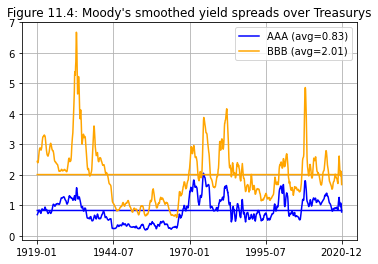

Spread and Treasury data starts 1919-01
AAA/BBB level correlation: 0.73878
AAA/Tsy difference correlation: -0.37118
BBB/Tsy difference correlation: -0.23964
AAA/BBB difference correlation: 0.67802


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
import qrpm_funcs as qf
#Get Moody's AAA and BBB yields from FRED.
#Splice together long-term US Treasury rate series,
#and subtract them off to form credit spreads.
#Display and correlate with VIX

def smooth_series(series,back):
#Smooth a time series by averaging "back" observations
    cum_series=np.cumsum(series)
    #Take averages
    smoo=(cum_series[back:]-cum_series[:-back])/back
    #Tack on stub at end
    return(np.concatenate((smoo, series[-back:]), axis=0))

lastday=qf.LastYearEnd()
seriesnames=['AAA','BAA','M1333AUSM156NNBR', \
             'LTGOVTBD','IRLTCT01USM156N']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            enddate=lastday)

#Splice together the three overlapping long-term
#Treasury series. They agree where they overlap
longterm=[]
for t in range(len(ratematrix)):
    #Take average of non-nan values of the overlapping series
    num_non_nan=np.count_nonzero(~np.isnan(ratematrix[t][2:5]))
    if num_non_nan==0:
        longterm.append(longterm[-1])   #propagate the previous value
    else:
        longterm.append(np.nansum(ratematrix[t][2:5])/num_non_nan)

n=len(longterm)

#time series of differences is rough - smooth it
#Roughness probably comes from different timings of
#observations of corporate yields and Treasurys
back=5  #Will take rolling back-month averages
aaa=[x[0]-y for (x,y) in zip(ratematrix,longterm)]
aaamean=np.mean(aaa)
aaa=smooth_series(aaa, back)

bbb=[x[1]-y for (x,y) in zip(ratematrix,longterm)]
bbbmean=np.mean(bbb)
bbb=smooth_series(bbb, back)

#Apply same transform to Treasurys for correlation
tsy=smooth_series(longterm, back)

#Show spread time series and straight line for averages
alabel='AAA (avg=%1.2f' % aaamean
alabel+=')'
plt.plot(range(n),aaa,label=alabel,color='blue')
plt.plot(range(n),[aaamean]*n,color='blue')
blabel='BBB (avg=%1.2f' % bbbmean
blabel+=')'
plt.plot(range(n),bbb,label=blabel,color='orange')
plt.plot(range(n),[bbbmean]*n,color='orange')

plt.legend()
plt.grid()
stride=int((n+1)/4)
places=np.arange(0,n+stride,stride)
places[len(places)-1]=n-1
displaydates=[cdates[j][:7] for j in places]    
plt.xticks(places,displaydates)
plt.title("Figure 11.4: Moody's smoothed yield spreads over Treasurys")
plt.show();

ab_level=scipy.stats.pearsonr(aaa,bbb)[0]
at_diff=scipy.stats.pearsonr(np.diff(aaa),np.diff(tsy))[0]
bt_diff=scipy.stats.pearsonr(np.diff(bbb),np.diff(tsy))[0]
ab_diff=scipy.stats.pearsonr(np.diff(aaa),np.diff(bbb))[0]
print("Spread and Treasury data starts",cdates[0][:7])
print("AAA/BBB level correlation: %.5f" % ab_level)
print("AAA/Tsy difference correlation: %.5f" % at_diff)
print("BBB/Tsy difference correlation: %.5f" % bt_diff)
print("AAA/BBB difference correlation: %.5f" % ab_diff)

For the 102 years from the beginning of 1919 to the end of 2020, AAA spreads averaged 83bps per year higher that US Treasurys. Table 11.3 showed that the cumulative default rate for AAA's was 90bps over 15 years. Recovery rates are about $45\%$ so the 15-year loss rate was about 51bps, or about 3bps per year. 

BBB spreads averaged 201bps per year over Treasurys; the 15-year default rate was 469bps, leading to roughly a $469*.56/15=18$bps/year loss rate.

So it appears that the spreads are too big compared to the loss rates they compensate for. We know that risk-neutral prices include a component of risk preference, and it seems reasonable that bondholders would be highly risk-averse. So spreads should be bigger than loss rates. But 83bps vs. 3bps? 201bps vs. 18bps?

One possibility is that we haven't really calculated the rates of return of investing in corporate bonds. AAA spreads are formed by taking the average of spreads of AAA bonds; when a bond is downgraded below AAA its spread increases and the bondholder suffers a negative return, but it is no longer included in the AAA spread calculation so that negative effect is not taken into account. Similarly if a BBB bond is either upgraded or downgraded out of the BBB category, it simply disappears from the calculation without any consequences.

So it would be more realistic to track the rates of return of groups of bonds. We do that in the next cell.

In [7]:
#Get total returns on IG, HY, and Treasury indices from FRED
from datetime import datetime, timedelta

seriesnames=['BAMLHYH0A0HYM2TRIV','BAMLCC0A0CMTRIV','DGS10']
xdates,xratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

#Put in dataframe
df_spreads = pd.DataFrame({'Date': pd.to_datetime(xdates), \
                           'HY': [row[0] for row in xratematrix], \
                           'IG': [row[1] for row in xratematrix], \
                           'Tsy': [row[2] for row in xratematrix]})
#Change to monthly and get rid of NAs
df_spreads=df_spreads.resample('M', on='Date').last().dropna()

#Convert Treasury rates to index levels. Only need final value of bond_idx
#Assume rates given are for 10-year par bond paying semiannually
bond_idx=[100.]*len(df_spreads)
T20=20   #20 semiannual periods

oldrate=df_spreads['Tsy'].iloc[0]/200.   #Semiannual rate
for i in range(len(df_spreads)-1):
    #Use formula (3.8) to get duration of par bond
    #Coupon and discount rate are from the old period
    y=1/(1+oldrate)
    #Duration is in half-years
    duration=(oldrate*y/(1-y)**2)*(1-y**T20-T20*(1-y)*y**T20)+T20*y**T20
    newrate=df_spreads['Tsy'].iloc[i+1]/200.
    #Return for the month
    bond_return=oldrate/6-duration*(newrate-oldrate)
    #Compute index levels for compatibility
    bond_idx[i+1]=bond_idx[i]*(1.+bond_return)
    oldrate=newrate

df_spreads['BondIndex'] = bond_idx   #Tack on the index-ized 10-year rates
    
#Format start and end dates and get elapsed time in years
dt_start = datetime.strftime(df_spreads['Date'].iloc[0],"%Y-%m-%d")
dt_end = datetime.strftime(df_spreads['Date'].iloc[-1],"%Y-%m-%d")
years=(df_spreads['Date'].iloc[-1]-df_spreads['Date'].iloc[0])/(timedelta(days=1)*365.25)

#Get annualized rates of return
tsy_annual=(df_spreads['BondIndex'].iloc[-1]/df_spreads['BondIndex'].iloc[0])**(1/years)-1.
ig_annual=(df_spreads['IG'].iloc[-1]/df_spreads['IG'].iloc[0])**(1/years)-1.
hy_annual=(df_spreads['HY'].iloc[-1]/df_spreads['HY'].iloc[0])**(1/years)-1.

#Get vols of log-returns of Tsy, IG, and HY
df_spreads['tsy_log_ret'] = np.log(df_spreads['BondIndex']).diff()
df_spreads['IG_log_ret'] = np.log(df_spreads['IG']).diff()
df_spreads['HY_log_ret'] = np.log(df_spreads['HY']).diff()

str_range="Annualized rates of return from "
str_range+=dt_start + " to " + dt_end + " (%4.1f" % years + " years)"

print(str_range)
print("US Treasury 10-year: %5.4f, Vol: %5.4f" % \
      (tsy_annual,np.sqrt(12.)*df_spreads['tsy_log_ret'].std()))
print("US Corp Master (IG): %5.4f, Vol: %5.4f" % \
      (ig_annual,np.sqrt(12.)*df_spreads['IG_log_ret'].std()))
print("  (spread over Tsy): %5.4f" % (ig_annual-tsy_annual))
print("US HY Master 2     : %5.4f, Vol: %5.4f" % \
      (hy_annual,np.sqrt(12.)*df_spreads['HY_log_ret'].std()))
print("  (spread over Tsy): %5.4f" % (hy_annual-tsy_annual))

Annualized rates of return from 1986-08-31 to 2020-12-31 (34.3 years)
US Treasury 10-year: 0.0599, Vol: 0.0743
US Corp Master (IG): 0.0710, Vol: 0.0530
  (spread over Tsy): 0.0111
US HY Master 2     : 0.0820, Vol: 0.0824
  (spread over Tsy): 0.0221


Since September 1986, investing in an index of investment grade bonds had a higher return than US Treasurys _while experiencing lower volatility_. The lower volatility is a result of negative rate/spread correlations; we'll explore that in Section 11.5 below. Speculative grade (high yield) bonds beat US Treasurys by even more, although with slightly higher volatility. These are (except for comparatively small transactions costs) realistic numbers that include price drops due to downgrades and defaults, as well as price increases due to upgrades and other positive news.

Thus the puzzle of (apparently) too-high credit spreads is real: corporate bonds, both investment grade and speculative grade, return quite a bit more than US Treasurys. The higher returns could be risk compensation, but (as with the spread/loss rate difference) the numbers intuitively seem too big for the risks involved, especially with investment-grade corporates.

[Krainer 2004](https://ideas.repec.org/a/fip/fedfel/y2004idec10n2004-36.html) reviewed some explanations for the credit spread: tax treatment, bond market illiquidity, and generally changing levels of systemic risk aversion that can't be diversified away. Krainer concludes that
>High-yield spreads are clearly tied to fundamentals such as future expected default rates. But spreads are also related to market liquidity in ways that are not yet well understood.

Peter Feldh&uuml;tter and Steven Schaefer left little doubt as to their point of view in the title of their 2018 paper: [The Myth of the Credit Spread Premium Puzzle](https://doi.org/10.1093/rfs/hhy032). In it, they argue that empirical tests of structural models have not calibrated on sufficiently long historical datasets. When they include data going back to the 1920s they find that a structural model fits observed credit spreads quite well for investment-grade corporate bonds, although there is still some unexplained spread in speculative-grade corporate bonds.

The debate continues, though, as [Bai, Goldstein and Yang 2018](https://dx.doi.org/10.2139/ssrn.3262310) examined Feldh&uuml;tter and Schaefer's methodology and find that
>...their results are reversed when their model is calibrated to *market* values of debt as required by theory rather than *book* values.

Below we'll explore what is meant by market value and book (par) value. While the credit spread premium changes depending on model and calibration, we do believe that the puzzle continues to exist: compensation for credit risk seems intuitively to be too high.

## 11.4 The Merton Model ##

We briefly described the [Merton Model](https://doi.org/10.1111%2Fj.1540-6261.1974.tb03058.x) in Section 9.5.1. Now we'll return to that model in greater detail.

Merton assumed that a corporate enterprise had borrowed a principal amount $D_{par}$ in the form of a single zero-coupon bond due at time $T$ from now. In order to be a [going concern](https://www.aicpa.org/research/standards/auditattest/downloadabledocuments/sas_132.pdf) and not enter bankruptcy, the company's enterprise value at time $T$, $V(T)$, will need to be at least $D_{par}$. Anything left over will go to the stockholders, so at time $T$ a going concern will have $V(T)=D_{par}+S(T)$ where $S(T)\geq0$ is the value of the company's stock (equity) at time $T$.

Merton assumed that the enterprise value $V$ follows a lognormal process like (3.22):[$^8$](#eleven_footnotes)
$$dV=\mu_V V dt+\sigma_V V d\beta\label{eq:merton_lognormal}\tag{11.4}$$
where $\mu_V$ is the enterprise value's mean return. An application of It&ocirc;'s lemma gives
$$dln(V)=(\mu_V-\sigma_V^2/2)dt+\sigma_V d\beta$$
Thus the logarithm of enterprise value follows a diffusion process that starts at the current point $ln(V(0))$. At time $T$ from now, log of enterprise value is normally distributed with mean $\mathbb{E}[ln(V(T))]=ln(V(0))+\bigl(\mu_V-\sigma_V^2/2\bigr)T$ and standard deviation $\sigma_V \sqrt{T}$.

The part of the time-$T$ distribution of enterprise values in which the company is in default is the part where $ln(V(T))<ln(D_{par})$. We can compute the **`distance to default`**, which is the number of standard deviations between the mean and the default threshold:
$$d_{Def}=\frac{\mathbb{E}[ln(V(T))]-ln(D_{par})}{\sigma_V\sqrt{T}}=\frac{ln(V(0)/D_{par})+\bigl(\mu_V-\frac{\sigma_V^2}{2}\bigr)T}{\sigma_V\sqrt{T}}\label{eq:merton_distance_default}\tag{11.5}$$
Under Merton's assumption that the diffusion process is normal, this means that the real-world (as opposed to risk-neutral) probability of default in the Merton model is $N(-d_{Def})$, where $N()$ is the standard normal cumulative distribution function.

Option pricing formulas can be used to obtain the risk-neutral (market-observed) prices of stock and debt. This follows from the observation that in addition to the going-concern case, we know the behavior of the non-going-concern (bankruptcy) case at time $T$. In that case $V(T)<D_{par}$ and $S(T)=0$; the lenders only get back a recovery fraction $V(T)/D_{par}<1$ of the amount they loaned. (As we've seen above that recovery fraction averages around $40-44\%$ of $D_{par}$.)

Both Merton and Black & Scholes pointed out that under these assumptions, the company's stock value $S$ has the same payoff pattern as a European call option.

In our notation, the [Black-Scholes-Merton call option pricing formula](https://doi.org/10.1086%2F260062) says
$$Call=S(0)=V\cdot N(d_1)-exp(-rT)D_{par}N(d_2)$$
$$d_1=\frac{ln(V(0)/D_{par})+\bigl(r+\frac{\sigma_V^2}{2}\bigr)T}{\sigma_V\sqrt{T}}\label{eq:black_scholes_merton}\tag{11.6}$$
$$d_2=d_1-\sigma_V\sqrt{T}$$

**`Put-call parity`**, also called the **`conversion equation`**, can be applied to this model to price debt. Put-call parity says that for European options on non-dividend-paying underlying assets $X$, we have:
$$V(0)+Put-S(0)=exp(-rT)D_{par}\label{eq:put_call_parity}\tag{11.7}$$
Here the put and the call (which is the stock $S(0)$) have the same underlyings, same maturities $T$, and same strike prices $D_{par}$. Put-Call parity follows from the fact that the left-hand side of \eqref{eq:put_call_parity} will always be worth $D_{par}$ at time $T$; either the put or the call will be in the money exactly enough to make up the difference between the underlying value $V(T)$ and the strike price $D_{par}$. The put's value is therefore
$$Put=-V\cdot N(-d_1)+exp(-rT)D_{par}N(-d_2)\label{eq:bsm_put}\tag{11.8}$$

Rearranging \eqref{eq:put_call_parity} and using the accounting identity $V(t)=S(t)+D(t)$,
$$V(0)-S(0)=D(0)=exp(-rT)D_{par}-Put\label{eq:parity_debt_value}\tag{11.9}$$
$exp(-rT)D_{par}$ is the current price of a default-free zero-coupon bond maturing at time $T$ from now at the par value of the debt. The possibility of default is reflected by subtracting the value of a put on $V$ struck at $D_{par}$ at time $T$ from now.

\eqref{eq:parity_debt_value} gives the current market value of the enterprise's debt $D(0)$. We can decompose the debt par value into three components:
$$D_{par}=D(0)+D_{par}(1-exp(-rT))+Put\label{eq:debt_market_value}\tag{11.10}$$
The $D_{par}(1-exp(-rT))$ term is the time value of the debt, while the put value gives the credit risk.

### 11.4.1 Merton's Term Structure of Credit Spreads ###

[Merton](https://doi.org/10.1111%2Fj.1540-6261.1974.tb03058.x) uses his debt value \eqref{eq:parity_debt_value} to compute a theoretical term structure of credit spreads. Define
$$Spr(T)=-\frac{1}{T}ln\bigl(\frac{D(0)}{D_{par}}\bigr)-r
=-\frac{1}{T}ln\bigl(\frac{exp(-rT)D_{par}-Put}{D_{par}}\bigr)-r
=-\frac{1}{T}ln\bigl(\frac{exp(-rT)D_{par}+V\cdot N(-d_1)-exp(-rT)D_{par}N(-d_2)}{D_{par}}\bigr)-r$$
$$=-\frac{1}{T}ln\bigl(1+\frac{1}{d}\cdot N(-d_1)-N(-d_2)\bigr)=-\frac{1}{T}ln\bigl(\frac{1}{d}N(-d_1)+N(d_2)\bigr)\label{eq:merton_spread_formula}\tag{11.13}$$
to be the spread over the risk-free rate $r$ due to credit risk, where $d$ is
$$d=\frac{D_{par}exp(-rT)}{V}$$
Merton calls $d$ the **`"quasi" debt-to-firm value ratio:`** it is a kind of leverage ratio.

Note from \eqref{eq:black_scholes_merton} that
$$d_1=\frac{-ln(d)+\frac{s^2}{2}}{s}\label{eq:merton_d_def}\tag{11.14}$$
where $s=\sigma_V\sqrt{T}$, and $d_2=d_1-s$. Thus $Spr(T)$ is actually a function of three variables: $\sigma_V$, $T$, and $d$.

Figure 11.6 is similar to Figure 1 in [Pitts and Selby](https://doi.org/10.1111/j.1540-6261.1983.tb02301.x), which corrects Merton's partially incorrect Figure 3.

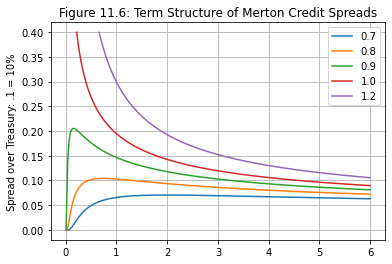

In [8]:
import scipy.stats as spst
#Graph sample term structure of credit spreads

def bsm_d1_2var(sig_sqrttime,dratio):
    #Black-Scholes-Merton d1
    return((-np.log(dratio)+(sig_sqrttime**2/2))/sig_sqrttime)
#End bsm_d1_2var

def bsm_d2_2var(sig_sqrttime,dratio):
    #Black-Scholes-Merton d2
    return(bsm_d1_2var(sig_sqrttime,dratio)-sig_sqrttime)
#End bsm_d2_2var

def merton_credit_spread(sigma,T,dratio):
    #Merton credit spread (see 11.13, equivalent to Merton (14))
    sigsqt=sigma*np.sqrt(T)
    d_1=bsm_d1_2var(sigsqt,dratio)
    d_2=bsm_d2_2var(sigsqt,dratio)
    log_arg=spst.norm.cdf(-d_1)/dratio+spst.norm.cdf(d_2)
    return(-np.log(log_arg)/T)
#End merton_credit_spread

sigma=np.sqrt(.2)
x=np.arange(.001,6.,.001)
for dratio in [.7,.8,.9,1.0,1.2]:
    y=[merton_credit_spread(sigma,t,dratio) for t in x]
    y2 = np.ma.masked_greater_equal(y, 0.4)
    plt.plot(x,y2,label=dratio)

plt.legend()
plt.grid()
plt.ylabel("Spread over Treasury: .1 = 10%")
plt.title("Figure 11.6: Term Structure of Merton Credit Spreads")
plt.show();

The parameters for Figure 11.6 describe highly indebted or near-insolvent companies with high enterprise volatility ($\sigma_V\approx$.45), so the credit spreads are dramatically high.

In the next section, we'll look at some actual values of these parameters.

### 11.4.2 Enterprise Value Example ###

Here's a [Bloomberg](https://www.bloomberg.com/company) enterprise value screen for the pharmaceutical giant [Johnson & Johnson](https://www.jnj.com/about-jnj). Moody's and Standard & Poor's both rate Johnson & Johnson ("JNJ") at the highest possible rating, i.e. in aggregate better than the US Treasury.

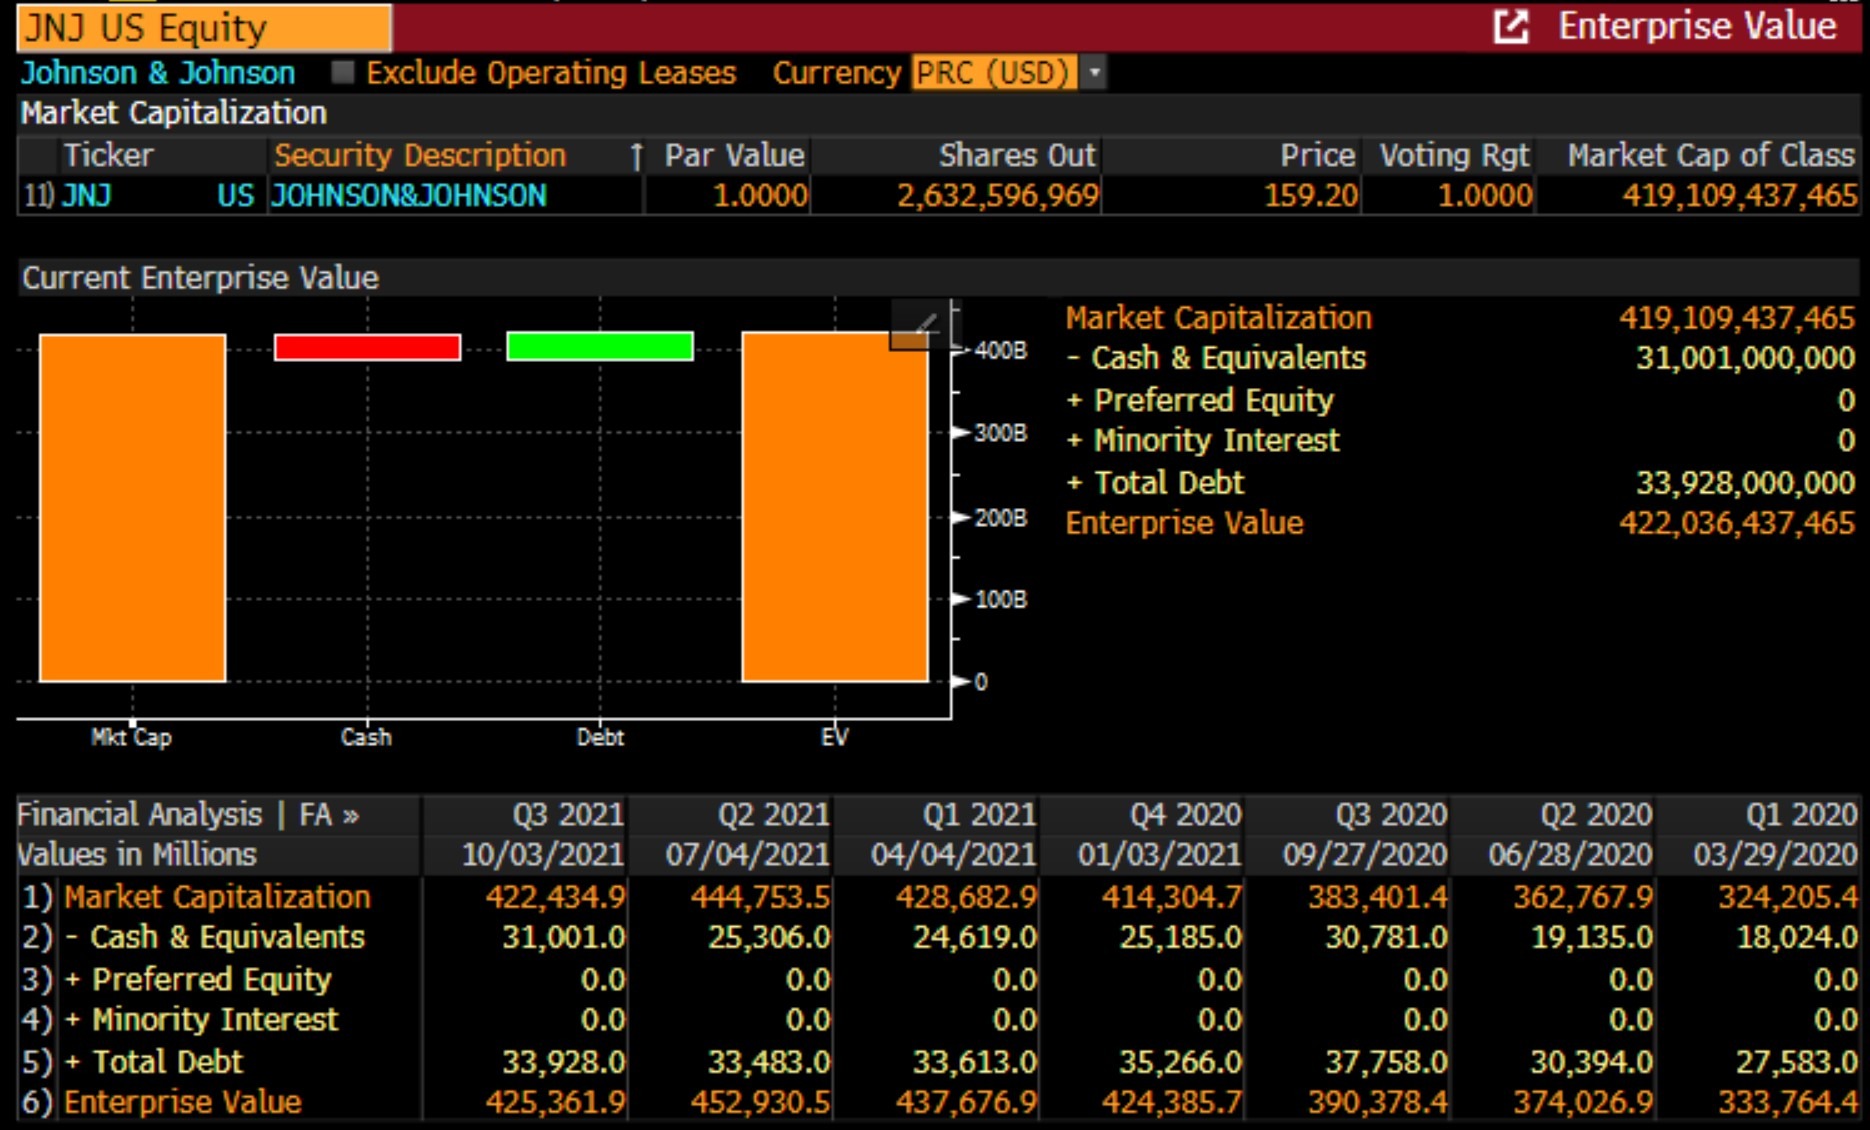

A simplified capital stack for JNJ looks like this:

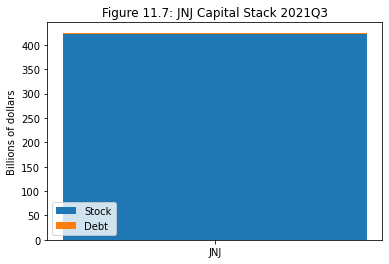

In [9]:
#Draw capital stack for JNJ

def show_capital_stack(ticker,title,stock,par_debt):
    labels = [ticker]
    bottom_tranche = [stock]
    top_tranche = [par_debt]
    width = 0.35

    plt.bar(labels, bottom_tranche, width, label='Stock')
    plt.bar(labels, top_tranche, width, bottom=bottom_tranche, label='Debt')

    plt.ylabel('Billions of dollars')
    plt.title(title)
    plt.legend()

    plt.show();
    
#Third quarter 2021
date_JNJ="2021Q3"
S_JNJ=422
D_par_JNJ=2.927
title="Figure 11.7: JNJ Capital Stack "+date_JNJ
show_capital_stack('JNJ',title,S_JNJ,D_par_JNJ)

We'll discuss some complications in estimating enterprise value below. For now we'll assume that enterprise value number is the sum of $S$ and $D_{par}$.

The code segment below plugs in JNJ's numbers, or first-pass estimates of them from observable numbers, in the formulas above. We've assumed &mdash; counterfactually, but in the spirit of the Merton model &mdash; that JNJ has a single zero-coupon debt issue maturing in $T=10$ years.

In [10]:
#Distance to default, d1, and black-scholes calculation
#For JNJ

def bsm_d1(underlying,strike,time,rfrate,sigma):
    #Black-Scholes-Merton d1
    return(bsm_d1_2var(sigma*np.sqrt(time),strike*np.exp(-rfrate*time)/underlying))
#End bsm_d1

def bsm_d2(underlying,strike,time,rfrate,sigma):
    #Black-Scholes-Merton d2=d_def
    return(bsm_d2_2var(sigma*np.sqrt(time),strike*np.exp(-rfrate*time)/underlying))
#End bsm_d2

def bsm(underlying,strike,time,rfrate,sigma):
    #Black-Scholes-Merton call price
    d_1=bsm_d1(underlying,strike,time,rfrate,sigma)
    d_2=bsm_d2(underlying,strike,time,rfrate,sigma)
    call_price=underlying*spst.norm.cdf(d_1)- \
        np.exp(-rfrate*time)*strike*spst.norm.cdf(d_2)
    return(call_price)
#End bsm

def show_merton_computations(name,S,D_par,sigma_S,r,T):
    #Rough calculation for enterprise value - see text below for 
    #better estimate
    V=S+D_par
    
    print('Ratios for %s:'% name)
    print('     D/V:',D_par/V)
    print('     D/S:',D_par/S)
    print('     S/V:',S/V)
    print(' ln(V/D):',np.log(V/D_par))

    #rough calculation for enterprise volatility - scale stock
    #volatility by S/V
    sigma_V = (S/V)*sigma_S
    print('\nComputations for %s:'% name)
    print('    S/V-scaled enterprise vol:',sigma_V)
    print('Risk-neutral growth rate r-sig^2/2:',r-sigma_V**2/2)

    #Risk-neutral distance to default
    d_def=bsm_d2(V,D_par,T,r,sigma_V)
    print("Risk-neutral distance to default:",d_def)
    print("   Default probability N(-d_def):",spst.norm.cdf(-d_def))

    #Black-Scholes
    Call_V=bsm(V,D_par,T,r,sigma_V)
    Put_V = np.exp(-r*T)*D_par-V+Call_V
    print("\nDebt components for %s:"% name)
    print("            Par value of debt:",D_par)
    print("       Time value of par debt:",D_par*(1-np.exp(-r*T)))
    print("         Value of default put:",Put_V)
    print(" Current market value of debt:",V-Call_V)
#End show_merton_computations

#Data for JNJ; assume (counterfactually) 10-year debt for illustrative purposes
#2021Q3 data from Bloomberg EV
#Treasury rate for 2021-09-30 from
#https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/
#    TextView.aspx?data=yieldYear&year=2021
ten_year_tsy=.0152
#From 2021-09-30 Bloomberg HIVG
sigma_S_JNJ=.19422
show_merton_computations('JNJ',S_JNJ,D_par_JNJ,sigma_S_JNJ,ten_year_tsy,10)

Ratios for JNJ:
     D/V: 0.006888241980387219
     D/S: 0.006936018957345972
     S/V: 0.9931117580196127
 ln(V/D): 4.977939381755539

Computations for JNJ:
    S/V-scaled enterprise vol: 0.1928821656425692
Risk-neutral growth rate r-sig^2/2: -0.0034017649114837494
Risk-neutral distance to default: 8.105494459100058
   Default probability N(-d_def): 2.6265718695851653e-16

Debt components for JNJ:
            Par value of debt: 2.927
       Time value of par debt: 0.4127413022707317
         Value of default put: 0.0
 Current market value of debt: 2.5142586977292467


Over ten years the Merton model gives virtually no chance of default, and assigns a value of close to zero to the default put. There is essentially no noticeable correction to the default-free debt model needed for Johnson & Johnson. Nonetheless, Johnson & Johnson bonds have a spread over US Treasurys of on the order of 57bps a year,[$^9$](#eleven_footnotes) consistent with the [credit spread premium puzzle](#spread_premium_puzzle). 10-year cumulative default rates for AAA bonds from Table 11.3 have averaged 70bps total, less than 7bps a year.

### 11.4.3 Model Improvement: Iterative Enterprise Value ###
<a name="iterative_enterprise_value"></a>

While the Bloomberg screen shows an enterprise value that we took to equal $V(0)$ above, enterprise value can't be directly observed. We can observe $D_{par}$, how much the company owes. If there is publicly traded stock, we can observe $S(0)$, the company's market value. But we then have to derive $D(0)$ or $V(0)$ from those observations.[$^{10}$](#eleven_footnotes) For good measure, then unobservability of $V(0)$ means that enterprise volatility $\sigma_V$ is also unobservable.

Fortunately there are iterative approaches that can be used to estimate current enterprise value $V(0)$ and enterprise volatility $\sigma_V$.

One approach[$^{11}$](#eleven_footnotes) applies It&ocirc;'s lemma to \eqref{eq:merton_lognormal} with $f(V)=Call(V)$. That gives the following expression as the coefficient of the random term $d\beta$:
$$\frac{\partial Call}{\partial V}\sigma_V V=N(d_1)\sigma_V V\label{enterprise_vol}\tag{11.20}$$

For a publicly traded company we can observe $\sigma_S$, the volatility of stock prices, through option-implied volatilities or directly from historical price data. Stock prices themselves are often modeled as lognormal processes, at least in the random diffusion term $d\beta$. In that case we can approximately equate the coefficients of the random terms to obtain
$$S\sigma_S\approx N(d_1)\sigma_V V$$
which gives
$$\sigma_V\approx \frac{S\sigma_S}{N(d_1)V}\label{eq:enterprise_vol_approx}\tag{11.21}$$

\eqref{eq:black_scholes_merton} and \eqref{eq:enterprise_vol_approx} give us two equations in the two unknowns $V$ and $\sigma_V$. The other quantities $r$, $T$, $S$, $\sigma_S$, and $D_{par}$ are observable.

The next code segment applies this approach to JNJ.

In [11]:
#Iterative solution of sigma-v and V for JNJ
#Using (11.6) and (11.11)
import numpy as np
import scipy.stats as spst

def form11_11(stock,value,sigma_stock,d_1):
    #Formula 11.11 for enterprise volatility
    return(stock*sigma_stock/(spst.norm.cdf(d_1)*value))

def iter_enterprise(name,stock,d_par,sigma_stock,rfree,time):
    #Search for V that solves S(=observed stock price)=bsm(V, sigmaV)
    #where sigmaV is according to 11.11
    #Bracket solution for binary search
    V0=d_par+stock/2 #Starting guess
    Vsmall, Vbig = 0, 2*V0
    threshhold = 10**(-8)
    count = 0
    while count < 200:
        #Try enterprise value in brackets
        V=(Vsmall+Vbig)/2
        d1=bsm_d1(V,d_par,time,rfree,sigma_stock)
        sigma_V=form11_11(stock,V,sigma_stock,d1)
        new_S=bsm(V,d_par,time,rfree,sigma_V)
        #Which way to go for binary search?
        if new_S-stock > threshhold:
            Vbig = V
        elif stock-new_S > threshhold:
            Vsmall = V
        else:
            break
        count+=1

    print('%s enterprise value at par:     %5.3f' % (name,stock+d_par))
    print('%s enterprise value at market:  %5.3f' % (name,V))
    print('%s enterprise volatility:       %5.3f' % (name,sigma_V))

    print('\n                                 D_par:',d_par)
    print('  Market value of debt (D_par-Put=V-S):',V-stock)
    print('                Time value of par debt:',d_par*(1-np.exp(-rfree*time)))
    print('             Implied default put value:',d_par*np.exp(-rfree*time)-V+stock)
    print('Default put value as a fraction of par:',np.exp(-rfree*time)-(V-stock)/d_par)
    print('                       d_1 at solution:',d1)
    print('(%d iterations for accuracy %e' % (count,threshhold)+')')
#Done with iter_enterprise    
    
#For JNJ
iter_enterprise('JNJ',S_JNJ,D_par_JNJ,sigma_S_JNJ,ten_year_tsy,10)

JNJ enterprise value at par:     424.927
JNJ enterprise value at market:  424.514
JNJ enterprise volatility:       0.193

                                 D_par: 2.927
  Market value of debt (D_par-Put=V-S): 2.5142586881776197
                Time value of par debt: 0.4127413022707317
             Implied default put value: 9.551627044857014e-09
Default put value as a fraction of par: 3.263289638510969e-09
                       d_1 at solution: 8.658041115789985
(33 iterations for accuracy 1.000000e-08)


With a more realistic enterprise value and volatility, there is now slightly more value to the default put over the next ten years. But it's still effectively zero, far less than the annual credit spreads that Johnson&Johnson bonds display in the market.

For a lower-rated company, consider [Charter Communications, Inc.](https://newsroom.charter.com/company-profile/) It is rated BB+/Ba2, i.e. speculative grade.

The Bloomberg enterprise value page for Charter shows the following:

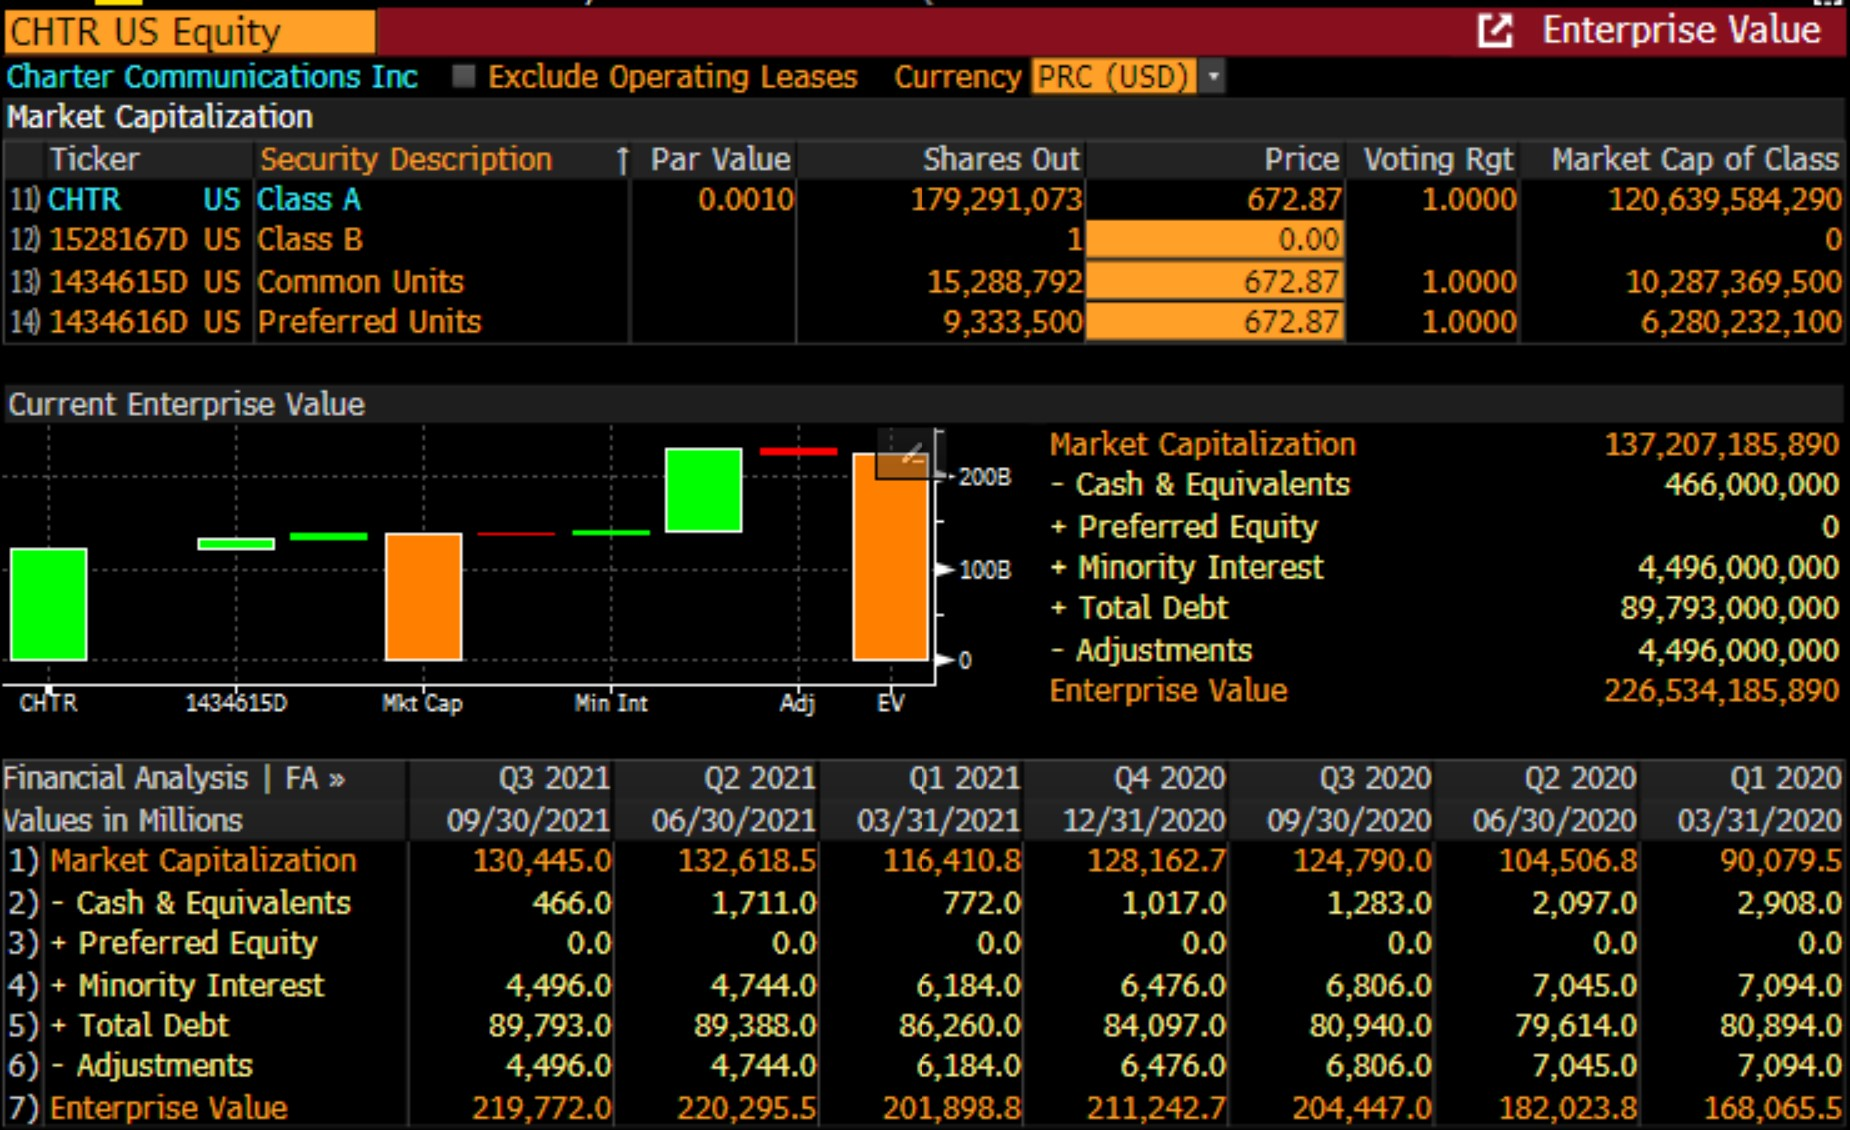

Charter's capital stack display is an immediate tipoff that it will have different behavior than Johnson & Johnson:

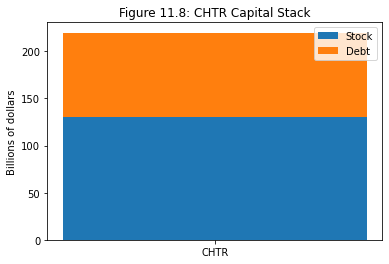

In [12]:
#Third quarter 2021
date_CHTR="2021Q3"
S_CHTR=130.445
D_par_CHTR=219.772-S_CHTR
title="Figure 11.8: CHTR Capital Stack"
show_capital_stack('CHTR',title,S_CHTR,D_par_CHTR)

Plugging in Charter's parameters to the iterative method and assuming for illustrative purposes 10-year debt, we obtain the following:

In [14]:
#Data for CHTR; assume (counterfactually) 10-year debt for illustrative purposes
sigma_S_CHTR=.28329   #From Bloomberg HIVG
iter_enterprise('CHTR',S_CHTR,D_par_CHTR,sigma_S_CHTR,ten_year_tsy,10)
#Bonds used for YAS: 4.75 of 3/1/30 on September 30, 2021: OAS of 325

CHTR enterprise value at par:     219.772
CHTR enterprise value at market:  205.579
CHTR enterprise volatility:       0.191

                                 D_par: 89.327
  Market value of debt (D_par-Put=V-S): 75.1338738507882
                Time value of par debt: 12.596153846237668
             Implied default put value: 1.596972302974109
Default put value as a fraction of par: 0.017877823087914413
                       d_1 at solution: 1.548032645486272
(31 iterations for accuracy 1.000000e-08)


Table 11.3 above showed a 10-year cumulative 1178bps average default rate for BB-rated bonds like Charter's. Assuming a $40\%$ recovery/$60\%$ loss rate, that's roughly an expected loss of 707bps. The default put value as a fraction of par is only 260bps, however. Actual credit spreads for long-term Charter debt are 257bps <u>*per year*</u>. While the order of magnitude of the default put is not quite as far off as with investment-grade debt, the pure structural model still underestimates actual spreads.

### 11.4.4 Model Improvement: KMV model ###

Merton's pure structural model is too elegant to survive in the wild. For example, large companies have a lot of different debt issues maturing at different times and usually paying coupons. This drives a wedge between the Merton model's mathematically tractable assumption of a single zero-coupon debt issue and the multi-date credit obligations of a real company. The simple European put option that contains the value of default is, in reality, more like a complicated barrier option: it might forcibly be exercised at a number of different times. This can radically change the value of the default option.

Another deep flaw: Chapter 7 pointed out that empirical financial distributions are almost always leptokurtic. The convenient assumption of lognormality is especially weak at the tails of distributions. Since defaults are neither common nor impossible, they generally live in the tails of distributions.

For example, Table 7.1 shows that a four standard deviation event would mean virtually no ($.3$bps) chance of default assuming lognormal returns. But Kealhofer[$^{12}$](#eleven_footnotes) notes that empirically, a four standard deviation distance to default is associated with approximately a $50$bps chance of default, i.e. such defaults are over $150$ times more common than lognormality implies.

Even with these flaws, the structural model can be useful for assessing ordinal if not cardinal default risks. Distance to default \eqref{eq:merton_distance_default} seems intuitively to be associated with its eponymous quality even if it is not exactly what it purports to be. So for example distance to default calculations might (with some adjustment) help a bank decide how much capital to set aside to protect against losses in its loan portfolio.

And perhaps the flaws can be corrected. With this in mind, [Stephen Kealhofer, John McQuown, and Oldrich Vasicek](https://www.moodysanalytics.com/about-us/history/kmv-history) put their initials together to form **`KMV`** in 1989. KMV computed **`expected default frequencies (EDFs)`** based on a modified version of the structural model. KMV was very successful and was acquired in 2002 by Moody's Corp, where it is now part of [Moody's Analytics](https://www.moodysanalytics.com/).

[Crosbie and Bohn (2003)](https://doi.org/10.1142/9789814759595_0020) describe the KMV model. They point out a number of unrealistic assumptions by the pure Merton model.

>In our study of defaults, we have found that generally firms do not default when their asset value reaches the book value of their total liabilities. While some firms certainly default at this point, many continue to trade and service their debts. The long-term nature of some of their liabilities provides these firms with some breathing room. We have found that the default point, the asset value at which the firm will default, generally lies somewhere between total liabilities and current, or short-term, liabilities.

Kealhofer,[$^{12}$](#eleven_footnotes) describing the KMV method, therefore makes the distance to default more practical than the pure Merton version \eqref{eq:merton_distance_default}:
$$d_{Def}^{KMV}(h)=\frac{ln(V)-ln(Default Point)+(\mu_V-\frac{\sigma_V^2}{2})h}{\sigma_V\sqrt{h}}\label{eq:KMV_distance_default}\tag{11.25}$$

Here $V$ is the market value of the enterprise's assets $\mu_v$ and $\sigma_V$ are the expected value and standard deviation of $V$ as in the Merton model \eqref{eq:merton_distance_default}. The parameter $h$ is the horizon (in years) over which the distance to default is to be computed. The default point takes into account the issues noted by Crosbie and Bohn.

Further, KMV take fat tails into account by using an empirical dataset rather than a lognormal assumption. For corporate bonds, they build a dataset of past characteristics and default indicators in order to associate distance to default \eqref{eq:KMV_distance_default} with observed default frequencies. That's where Kealhofer got the $50$bps estimate of default frequency for a four distance to default cited above.

To estimate the unobservable $V$ and $\sigma_V$, KMV-type models use an [iterative method](#iterative_enterprise_value) like the one we saw above. By using historical information as well as current information, these models can converge on reasonable estimates for the unknowns.

The KMV method starts by making a guess as to the current enterprise value of the company in question, denoted by $V_0^0$. The market value of the company's stock at the present time, denoted by $S_0$, can be observed if it's publicly listed. If not, a factor model as in Chapter 6 can be used so that company characteristics like book-to-price, market capitalization, and industry can be projected into an estimated market value. The equity (stock) volatility $\sigma_S$ can also be observed either from implied volatilities of the company's options, or from historical log-prices, or from historical factors projected into log-prices. An initial guess as to enterprise volatility $\sigma_{V,0}$ can be made with a simple proportional estimate $\sigma_{V,0}=\frac{\sigma_S S_0}{V_0^0}$.

So far the method is the same as the simple Merton model, with extended notation. But then KMV begins to diverge. Instead of a European option valuation formula, KMV use a custom option pricing formula developed by Vasicek and Kealhofer (the "VK" formula). The VK formula prices a perpetual option where the strike price (the default point) is an absorbing barrier &mdash; whenever the enterprise value hits the default point, the firm is forced to default. The firm can't wait until some future expiration date to recover. The default point takes into account points at which similar firms have defaulted in the past and looks at multiple classes of the firm's liabilities.

KMV then uses the VK option formula to compute an implied time series of past enterprise values $V_0^t$, $t=0,\dots,T$ where a higher $t$ means further in the past; $t=0$ is the present.
$$[Market-Value-of-Stock]_t=VK(V_0^t,\sigma_{V,0},DP,r)\label{eq:kmv_stock_iter_start}\tag{11.26}$$
In \eqref{eq:kmv_stock_iter_start}, all but one variable is either observable (historical market values of stock; default point $DP$ computed from capital structure of the firm and analysis of comparable firms; risk-free rate $r$) or previously assumed (enterprise value volatility $\sigma_{V,0}$). The variable left to be computed at each time period is the implied enterprise value $V_0^t$.

\eqref{eq:kmv_stock_iter_start} is used to form a time series of enterprise values $V_0^t$. The sample volatility $\sigma_{V,1}$ of this time series can then be computed and the process repeated again and again for $i=1,\dots$ until it converges:
$$[Market-Value-of-Stock]_t=VK(V_i^t,\sigma_{V,i},DP,r)\label{eq:kmv_stock_iter_general}\tag{11.27}$$
The $i^{th}$ iteration inputs $\sigma_{V,i}$ and outputs $\sigma_{V,i+1}$. When these are sufficiently close to each other, say at iteration $n$, the process stops. At that point the values $V_n^0$ and $\sigma_{V,n}$ can be used as current enterprise value and current enterprise volatility, respectively.

Table 11.6 | First Four Steps of KMV iterative method |
------------- | ------------- |

| Step 1: Get time series $V_0^t$ |  Step 2: Compute $\sigma_{V,1}$ from time series |  Step 3: Get time series $V_1^5$  |  Step 4: Compute $\sigma_{V,2}$ from time series$\dots$  |
|----|:----:|:----:|:----:|
| $[MVS]_0=VK(V_0^0,\sigma_{V,0},DP,r)$  | $V_0^0$ | $[MVS]_0=VK(V_1^0,\sigma_{V,1},DP,r)$ | $V_1^0$ |
| $[MVS]_1=VK(V_0^1,\sigma_{V,0},DP,r)$  | $V_0^1$ | $[MVS]_1=VK(V_1^1,\sigma_{V,1},DP,r)$ | $V_1^1$ |
| $\dots$  | $\dots$ | $\dots$ | $\dots$ |
| $[MVS]_T=VK(V_0^T,\sigma_{V,0},DP,r)$  | $V_0^T$ | $[MVS]_0=VK(V_1^T,\sigma_{V,1},DP,r)$ | $V_1^T$ |

Much of this effect is due to the use of stock market information in the KMV method: for most companies, the stock market very quickly impounds new information in prices while ratings agencies are deliberate in re-rating bonds. Thus much of the power of methods like KMV consists of using new but widely known information quickly. Bond traders and portfolio managers would already be well aware of this information before seeing KMV estimates. Still, having the information in a convenient expected default frequency number is quite useful.

### 11.4.5 Predictive Power of Default Estimates ###

It's clear from Figure 11.1 that the bifurcation of bonds into investment and speculative grades is meaningful: there has never been a year in which investment grade defaults were greater than speculative grade defaults, for example. On the other hand, there's plenty of room for improvement: two broad categories are not very informative. The average man is significantly taller than the average woman, but basketball star [Breanna Stewart](https://www.wnba.com/player/breanna-stewart/) is even more significantly taller than the average man.

In fact it's easy to predict defaults better than agency ratings: just predict that everything will default. Of course that extreme level of caution will be maximally bad in terms of **`Type II error`** (the prediction of events that do not occur). Similarly being extremely reckless and predicting that nothing will default will never mistakenly sound the alarm (no Type II error), but will be maximally bad in terms of **`Type I error`** (the underprediction of events that do occur).

What is needed is a balancing act between Type I error and Type II error. Suppose there is a sliding scale like distance to default \eqref{eq:KMV_distance_default} or agency rating level (AAA down to D, translated to a numerical scale), and an analyst is trying to decide where to set the cutoff between predicting default and not predicting default. There are about twenty agency rating levels (including $+$ and $-$ notches), and distance to default is continuous, so there are ample opportunities to decide where to set a cutoff to get the best Type I/Type II tradeoff.

An extremely cautious analyst would say that a bond is not safe until distance to default is infinite, or until its rating is (impossibly) better than AAA. At these levels of hypercaution, the proportion $x$ of bonds predicted to default would be $x=1$ (all of them). At the other end of the scale, an extremely reckless analyst would deem bonds safe at any distance to default or at any credit rating: for this analyst $x=0$ (no bonds predicted to default).

For such a scale of caution/recklessness that maps a parameter onto the interval $x\in[0,1]$ of fraction of bonds predicted to default, define $t_1(x)$ ($t_2(x)$) as the standardized fraction of bonds experiencing Type I (Type II) error. By "standardized," we mean adjusted for the fraction of the population $q$ that actually does default.

For example, at maximum caution $x=1$, $t_1(1)=0$ and the fraction of bonds experiencing Type II error will be $1-q$, so we define $t_2(x)$ as the fraction of bonds experiencing Type II error, divided by $1-q$. Similarly at maximum recklessness $x=0$, $t_2(0)=0$ and Type I error is $q$, so we define $t_1(x)$ as the fraction of bonds experiencing Type I error, divided by $q$. Thus $t_1$ and $t_2$ both have domain and range equal to $[0,1]$; $t_1(x)$ is decreasing in $x$ and $t_2(x)$ is increasing in $x$.

What happens in between the extremes can differ. A parameter like distance to default or credit rating would be good if it minimized Type I error for a given level of Type II error. Thus Kealhofer[${^12}$](#eleven_footnotes) proposes a power measure
$$p(x)=1-t_1(t_2^{-1}(x))\label{eq:kealhofer_power}\tag{11.28}$$
to balance Type I and Type II error. At the cautious end of the domain $x=1$, Type II error is $1-q$ so $t_2(1)=1$, giving $t_2^{-1}(1)=1$. Hypercaution means no Type I error, so $t_1(1)=0$: hence $p(1)=1-t_1(1)=1$. At the reckless end of the domain $x=0$, Type II error is $0$ so $t_2(0)=0$, giving $t_2^{-1}(0)=0$. Recklessness maximizes Type I error, so $t_1(0)=1$: hence $p(0)=1-t_1(0)=0$.

$p$ is something like a cumulative distribution function with domain $[0,1]$. A more desirable $p$ is stochastically dominated by a less desirable $p$, as it is preferable for $p$ to head to $1$ (no Type I error) as quickly as possible.

While Kealhofer[$^{12}$](#eleven_footnotes) is of course not a disinterested observer, he shows evidence that the $p$-curves for the KMV method are stochastically dominated by the $p$-curves for credit ratings, i.e. the KMV method has a better power curve.

A predictive method with a good power curve can help lenders make money, as they want to minimize Type I error in the loans they do make and they want to minimize Type II error in the loans they don't make. However the time-varying nature of overall default levels can be damaging: just getting things right on average over a long period of time can be of little comfort during a severe economic meltdown. So power consistency over time is also important.

There is little evidence that ratings or default frequency estimates help bond market investors make money by revealing previously unknown default information. Bond ratings are essentially public information,[$^{13}$](#eleven_footnotes) so rating changes are quickly reflected in bond prices and confer no competitive advantage on any particular investor.

Default frequency estimators like KMV rely heavily on stock market levels as inputs, so the majority of information has already been reflected in market prices. Kealhofer,[$^{14}$](#eleven_footnotes) summarizing an earlier study by Vasicek that showed KMV EDFs predicting over- and under-pricing of bonds, disclaims a profitable arbitrage strategy and attributes the reveal over- and under-pricing to bad market making:
>This result is consistent with findings that reported bond pricing does not necessarily reflect actual trades, but, rather, dealer indications or model prices.

Ironically one popular money-making strategy based on credit ratings is to buy "fallen angels," bonds that have been downgraded from investment to speculative grade. Proponents of this strategy point out that many investors have statutory or regulatory requirements to hold only investment grade bonds, so they become forced sellers after a downgrade. The fallen angel buyers hope that this leads to an overreaction (too big a price drop) that unconstrained investors can benefit from. The success of this strategy depends on (a) how many other investors are following the same strategy; and (b) timing, as buying fallen angels just before a market crash will probably be unprofitable.

## 11.5 Credit Spread Correlates ##

While structural models continue to have puzzling faults, their prediction that volatility is an important factor in explaining credit spreads is certainly borne out empirically. The next cell computes correlations between the time series of the [VIX Index](http://www.cboe.com/vix) of option-implied volatilities on the US Stock market and the time series of credit spreads that was shown above in Figure 11.4.

In [12]:
#Get VIX index (which is daily)
vxnames=['VXOCLS','VIXCLS']
vxdates,vxmatrix=qf.GetFREDMatrix(vxnames,enddate=lastday)

#Align VIX's; monthly dates for bond yields look like
#YYYY-MM-01 but they're really the last business day
vixstart=cdates.index(vxdates[0][:8]+'01')
iv=0
for ic in range(vixstart,len(cdates)):
    #New month coming up in VIX series?
    while True:
        usethisguy=(iv==len(vxdates)-1)
        if not usethisguy:
            usethisguy=(vxdates[iv][5:7]!=vxdates[iv+1][5:7])
        if usethisguy:
            #Look for non-NaN
            looking=True
            while looking:
                vix=vxmatrix[iv][1]
                looking=np.isnan(vix)
                if looking:
                    vix=vxmatrix[iv][0]
                    #Are both nan?
                    looking=np.isnan(vix)
                    if looking:
                        iv+=1  #Try next date
            #Found a non-NaN VIX
            #Append VIX value to data
            ratematrix[ic].append(vix)
            iv+=1
            break
        iv+=1

#Smooth VIX
vix=[x[5] for x in ratematrix[vixstart:]]
vix2=np.cumsum(vix)
vix3=(vix2[back:]-vix2[:-back])/back
vix=np.concatenate((vix3, vix[-back:]), axis=0)

#Correlate smoothed spreads with VIX
av_level,av_pvalue=scipy.stats.pearsonr(vix,aaa[vixstart:])
bv_level,bv_pvalue=scipy.stats.pearsonr(vix,bbb[vixstart:])
av_diff,avd_pvalue=scipy.stats.pearsonr(np.diff(vix),np.diff(aaa[vixstart:]))
bv_diff,bvd_pvalue=scipy.stats.pearsonr(np.diff(vix),np.diff(bbb[vixstart:]))
print("VIX data starts",cdates[vixstart][:7],"ends",cdates[-1][:7]+";",len(vix),"periods")
print("AAA/VIX level correlation: %.5f" % av_level)
print("BBB/VIX level correlation: %.5f" % bv_level)
print("AAA/VIX difference correlation: %.5f" % av_diff)
print("BBB/VIX difference correlation: %.5f" % bv_diff)
high_pvalue=max(av_pvalue,bv_pvalue,avd_pvalue,bvd_pvalue)
print("Reject null hypothesis of zero correlation with\n"+ \
      "    probability at least one minus:",high_pvalue)

VIX data starts 1986-01 ends 2020-12; 420 periods
AAA/VIX level correlation: 0.49938
BBB/VIX level correlation: 0.66036
AAA/VIX difference correlation: 0.44499
BBB/VIX difference correlation: 0.48978
Reject null hypothesis of zero correlation with
    probability at least one minus: 9.068624822008345e-22


Both level-based and difference-based correlations are high and significantly different from zero. Thus over long periods of time, a large portion of credit spread movement is due to changes in market volatility. The connection is most pronounced during market shocks when both volatilities and credit spreads suddenly expand; during other times the connection can be more tenuous.

Credit spreads also often have a relationship to interest rates. Generally when the economy is doing well, interest rates rise as (1) people and companies are more eager to borrow to finance current consumption and investment; and (2) the central bank raises rates to cool things off. During such good economic times, corporate health also improves and credit spreads tighten as the compensation for the risk of default seems less necessary. This reverses during bad times: falling interest rates, widening credit spreads.

This dynamic is similar to the one shown in Figure 10.6, where stock/bond correlations were shown to be negative since the 1990s. However credit spread/interest rate correlations in the US have been reliably negative for all but one of the last ten decades, as Figure 11.8 shows:

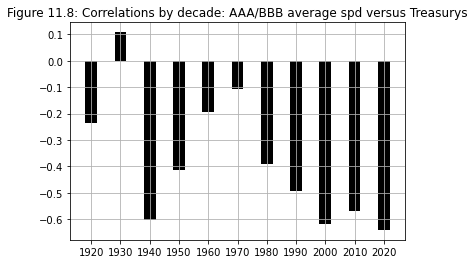

Spread and Treasury data starts 1919-01 ends 2020-12; periods: 1224
AAA/Tsy difference correlation: -0.37118 p-value: 3.046061911264286e-41
BBB/Tsy difference correlation: -0.23964 p-value: 1.9638588657289755e-17


In [13]:
#Show correlations by decade rates/spreads

lastdecade=int(lastday[:3])
lastdecade*=10
decades=np.arange(1920,lastdecade+1,10)

decade_starts=[]
for d in decades:
    decade_string=str(d)+'-01-01'
    decade_starts.append(cdates.index(decade_string))
    
#Close out most recent decade
decade_starts.append(len(cdates))

decade_correlations=[]
for i,d in enumerate(decades):
    avgspd_decade=( \
        aaa[decade_starts[i]:decade_starts[i+1]]+ \
        bbb[decade_starts[i]:decade_starts[i+1]])/2
    tsy_decade=tsy[decade_starts[i]:decade_starts[i+1]]
    avgt_diff=scipy.stats.pearsonr(np.diff(avgspd_decade),np.diff(tsy_decade))[0]
    decade_correlations.append(avgt_diff)

#Display bar chart
indices=np.arange(len(decades))
width = 0.4
plt.bar(indices,decade_correlations,width,color='black')
plt.grid()
plt.xticks(indices,decades)
plt.title("Figure 11.8: Correlations by decade: AAA/BBB average spd versus Treasurys")
plt.show();

at_diff,at_pvalue=scipy.stats.pearsonr(np.diff(aaa),np.diff(tsy))
bt_diff,bt_pvalue=scipy.stats.pearsonr(np.diff(bbb),np.diff(tsy))

print("Spread and Treasury data starts",cdates[0][:7],"ends",cdates[-1][:7]+";", \
     "periods:",len(cdates))
print("AAA/Tsy difference correlation: %.5f" % at_diff,"p-value:",at_pvalue)
print("BBB/Tsy difference correlation: %.5f" % bt_diff,"p-value:",bt_pvalue)

While most decades have a clearly negative correlation, the 1930s show that unusual economic stress, together with fiscal and monetary response, can cause a regime shift. There was a slightly positive correlation between rates and spreads in the 1930s: as in Argentina and other credit-risky countries, the survival of the country's overall economy became the single paramount factor linking rates and spreads. In other words, there was doubt that the default-free rate really was default-free.

## 11.6 Credit Spread Metrics ##

In Chapter 3 we found that Macaulay duration and modified duration were eminently reasonable first-order measures of bond return sensitivity to changes in interest rates. For default-free instruments with simple cash flows, these definitions of duration suffice. But as the instruments get more complex, the cash flows $c_i$ (and possibly their times $t_i$) contemplated in the generic pricing equation (3.2) also become more complex.

A common feature in a corporate bond, for example, is a **`call schedule`**: the borrower can pay off the principal early if it wants to retire the debt. Usually this will only happen if prevailing rates have dropped, leaving the lender with an unwanted return of principal in a low-interest environment. We noted earlier that this can lead to lower, or even negative, convexity.

Of course credit risk can cause the cash flows to drop due to the borrower's inability to repay. If a credit-risky bond defaults before maturity, repayment of any recovery amount will be accelerated, decreasing duration. Or the cash flows can be based on a formula that floats with the current rate of interest. Thus there can be a breakdown in the equivalence between (1) Macaulay's original concept of duration as the average time at which cash flows are received; and (2) a multiple of the first derivative of the price with regard to a parallel shift in the discount curve. 

Equation (3.7) – in which we explicitly showed the relationship between cash flows and first and second derivatives – can become difficult to evaluate if the cash flows are contingent on future events. Here $y=1/(1+r)$, $r$ the discount rate:
$$P_t^{\prime}=-y\sum_{i=m}^n(t_i-t)c_i y^{t_i-t}\qquad 
P_t^{\prime\prime}=y^2\bigl(\sum_{i=m}^n(t_i-t)^2c_i y^{t_i-t}\bigr)-yP_t^{\prime}
\tag{3.7, again}$$

Instruments may even be path-dependent. For example, **`knockout options`** automatically exercise themselves as soon as the underlying asset goes above or below certain prices. If we knew that a bond was at $100$ at inception of a knockout option and was again at $100$ at maturity of the knockout option, we wouldn't have enough information to know how the option would have behaved. If the knockout strike was at $90$, then if the bond's price looked like $100(1+sin(\pi t)/2)$ as $t$ went from $0$ at inception to $1$ at maturity, the knockout would not have been triggered. But with a price path looking like $100(1-sin(\pi t)/2)$, the option would have exercised.

To take into account these complexities, we assume there is a pricing function $P(r,s)$ that takes a number of arguments, only two of which we list explicitly: $r$, the vector (or continuous function) of default-free discount rates; and $s$, the scalar spread that we need to add to the default-free discount rates to make the price of the bond equal the market observed price.

In \eqref{eq:discrete_credit} and \eqref{eq:continuous_credit} we showed a simple version of the pricing formula as a function of a credit spread. However when there are complex features to the bond, we may need to use a Monte Carlo simulation run over many possible paths of interest rates or credit events to see what the price should be. The spread $s$ that makes the more complex pricing function equal the market price is called the **`option-adjusted spread (OAS)`**.

**`Effective duration`** is a generalization of the durations we've previously seen. To compute effective duration, the $r$ vector in the complex pricing function $P(r,s)$ is perturbed by a small scalar amount $\Delta r$, so $r$ becomes $r\pm u\Delta r$, where $u$ is the vector of all ones. This gives a finite difference approximation to the (negative of) the derivative of the price with respect to a parallel shift in the discount curve:
$$D_E(r,s,\Delta r)=\frac{P(r-u\Delta r,s)-P(r+u\Delta r,s)}{2\Delta r P(r,s)}\label{eq:effective_duration}\tag{11.30}$$
Similarly we can define **`effective convexity`** as a finite difference approximation to the second derivative divided by price:
$$C_E(r,s,\Delta r)=\frac{P(r-u\Delta r,s)-2P(r,s)+P(r+u\Delta r,s)}{(\Delta r)^2P(r,s)}$$
$$\approx\frac{D_E(r-u(\Delta r/2),s,\Delta r/2)-D_E(r+u(\Delta r/2),s,\Delta r/2)}
{\Delta r P(r,s)}\label{eq:effective_convexity}\tag{11.31}$$
The second line of \eqref{effective_convexity} is an approximation, not an equality, because the denominators of the $D_E$'s are not quite the same as the denominator in the definitional first line. The difference is a higher-order effect so it's usually not noticeable.

The effective duration $D_E$ will approximate a suitably scaled version of our previous definitions of duration when the cash flows are simple enough, but in the presence of optionality, floating rates, and possible default, $D_E$ may differ. Similarly for effective convexity.

We can also define **`option-adjusted spread duration (OASD)`**. Not surprisingly, this is:
$$OASD(r,s,\Delta s)=\frac{P(r,s-u\Delta s)-P(r,s+u\Delta s)}{2\Delta s P(r,s)}\label{eq:OASD_definition}\tag{11.32}$$

The definition \eqref{eq:effective_duration} of effective duration contemplates adding (and subtracting) a scalar perturbation $\Delta r$ to every point on the discount curve. The definition \eqref{eq:OASD_duration} of spread duration contemplates adding (or subtracting) a scalar perturbation $\Delta s$ to the scalar $s$ that is already being added to the discount curve. In both cases, the discount factor is changed from $r_i$ to $r_i+\Delta something$. So shouldn't spread duration be the same as effective duration?

In many cases the two are equal. However when optionality or the coupon in a bond depends on rates but not on spread, then effective duration (sometimes called rate duration) and spread duration can differ. For example, when the discount curve is flat a default-free floating-rate security maturing in 30 years will have effective duration close to zero, but very long spread duration.

Risk in credit portfolios is often assessed by spread duration exposure. A manager might say "I'm 2 years long telecoms spread duration." As we noted with overall duration, spread duration only makes sense as a measure when it is applied to similar things. For example a year's spread duration of the African mobile telecom operator [MTN Limited](https://www.mtn.com/) is not really comparable to a year's spread duration of [China Mobile Limited](https://www.chinamobileltd.com/en/global/home.php).

## 11.7 Credit factor models ##

Fixed income portfolios often use factor models like the ones we saw in Chapter 6:
$$C=BFB^{\prime}+D\tag{6.40, again}$$
Recall that $B$ is an $n\times k$ factor loading matrix giving the exposures of the $n>>k$ securities in the universe to the comparatively small number of systematic factors explaining the market's behavior. $D$ is a (sometimes omitted) diagonal matrix of systematic risks uncorrelated with anything else.

For fixed income factor risk models, the $k$ factors usually consist mainly of the following:
1. Key rate durations on a number of default-free curves, or more precisely the moves of rates at certain points of the curve; and
2. Spread movements for key sectors like UK investment-grade financials.

For a given security $x$, its first-order Taylor series approximation may look like
$$\frac{\Delta P_x}{P_x}=\theta\Delta t-\sum_i\bigl(KRD_{x,i}\Delta r_i\bigr)-SD_x \Delta s_x\label{credit_taylor}\tag{11.35}$$
Here $KRD_{x,i}$ is the security's key rate duration to the $i^{th}$ point on the security's discount curve &mdash; for example the US Treasury curve for US corporate bonds or the Japanese government curve for Japanese corporate bonds. $\Delta r_i$ is the movement of the yield curve at that point. $SD_x$ is the bond's spread duration (usually zero if this is a default-free government bond. although there can be small spreads on government bonds since yield curves are not perfect). $\Delta s_x$ is the move in the bond's own spread. $\theta$ is the sensitivity to the passage of time, including carry (which captures regular payments like coupons) and rolldown (Section 3.5.5). While carry and rolldown influence rates of return, they are known in advance so they're not considered risk factors.

When modelers want to capture systematic risk, $\Delta s_x$ might be replaced by $\Delta s_j$, where $j$ is a group that the instrument belongs to and that (it is hoped) has homogeneous within-group spread movements. For example, the sector might be UK investment grade financials. The risk factors going into the factor covariance matrix $F$ in (6.40) would then be: (1) changes in rates $\Delta r_i$; and (2) changes in group spreads $\Delta s_j$.

However, substituting a cohort spread change $\Delta s_j$ for a security spread change $\Delta s_x$ might not be realistic: the cohort spread level $s_j$ might be significantly different than the security spread level $s_x$, so changes, while perhaps highly correlated, might be of different sizes. One popular substitution is called **`Duration Times Spread (DTS)`** and is based on the tautological identity
$$SD_x \Delta s_x=\bigl(SD_xs_x\bigr)\frac{\Delta s_x}{s_x}\label{eq:DTS_x}\tag{11.36}$$
The $SD_x s_x$ term multiplies $x$'s duration times its spread, hence the name DTS. DTS is considered the exposure metric, and $\frac{\Delta s_x}{s_x}$, which is a percentage change in $x$'s spread, is the variable to which $x$ is exposed. $\frac{\Delta s_x}{s_x}$ is likely to be more statistically well-behaved than $\Delta s_x$ and thus is likely to be more predictable.

In a factor model, individual variables like $\frac{\Delta s_x}{s_x}$ are modeled by systematic factors. It is not unreasonable to assume that $x$'s spread percentage changes would be similar to spread percentage changes in its cohort $j$:
$$\frac{\Delta s_x}{s_x}\approx\frac{\Delta s_j}{s_j}\label{eq:DTS_approx}\tag{11.37}$$
This is likely to be a much better substitution than $\Delta s_j$ for $\Delta s_x$. Thus in the DTS model the contribution to $x$'s security return coming from $x$'s spread changes is assumed to be
$$SD_x \Delta s_x\approx\bigl(SD_xs_x\bigr)\frac{\Delta s_j}{s_j}\label{eq:DTS_j}\tag{11.38}$$
DTS ($SD_xs_x$) is the exposure metric and $\frac{\Delta s_j}{s_j}$ is the risk factor to which the asset's returns are exposed.

The DTS approach has the drawback that the exposure metric can change rapidly. Spread duration $SD_x$ changes as discount curves and spreads change, but typically changes slowly over time. But spread $s_x$ can change quite rapidly. This makes a portfolio manager's task difficult: the manager might decide today on a certain exposure to a risk factor $\frac{\Delta s_j}{s_j}$, but tomorrow changing market conditions can radically change the exposure. This might give the manager the choice of staying with an exposure that was not desired, or of excessive trading just to maintain the desired exposure. In a nutshell: DTS is a moving target.

Another approach that has less of a moving-target problem is **`adjusted spread duration`**. It starts with a tautology like \eqref{eq:DTS_x}:
$$SD_x \Delta s_x=\bigl(SD_x\frac{s_x}{s_j}\bigr)\frac{s_j}{s_x}\Delta s_x\label{eq:ASD_x}\tag{11.39}$$
An approximation similar to \eqref{eq:DTS_approx} is then made:
$$\frac{s_j}{s_x}\Delta s_x\approx\Delta s_j\label{eq:ASD_approx}\tag{11.40}$$
This approximation takes into account the possibly different sizes of security spreads $s_x$ and cohort spreads $s_j$. Putting these together, the adjusted spread duration model is
$$SD_x \Delta s_x\approx\bigl(SD_x\frac{s_x}{s_j}\bigr)\Delta s_j\label{eq:ASD_j}\tag{11.41}$$
Adjusted spread duration $SD_x\frac{s_x}{s_j}$ is the exposure metric, which is likely to move far more slowly than DTS. The risk factor $\Delta s_j$ contains changes in cohort credit spreads. This risk factor is likely to be more badly behaved (leptokurtic, for example) than percentage changes $\frac{\Delta s_j}{s_j}$, but the bad behavior can be addressed with GARCH-type models. de-GARCHed spread changes are at least as good risk model citizens as are percentage spread changes.

## 11.8 Z-Scores, Reduced-Form, and Hybrid Models ##

Because of the disproportionate importance of default, many methods have been used to try to predict defaults. In addition to the Merton model discussed in Section 11.4, quantitative methods based on accounting and economic data have had success.

Credit ratings use accounting and economic data, but they aren't purely quantitative. While criteria like debt-to-equity ratios are used by credit rating company analysts, there isn't an exact formula associated ratings with criteria. Tables like Table 11.3 and Table 11.5 show historical default frequencies for cohorts of issuers and ratings, but we know these averages belie considerable variability over different economic conditions.

[Edward Altman](https://www.stern.nyu.edu/faculty/bio/edward-altman) originated a quantitative method to tie default probabilities to observable accounting criteria. Rating agencies had been doing this qualitatively when assigning ratings; eventually they began compiling data such as Table 11.2 to show the relationships between accounting features and ratings assigned by analysts. Altman dispensed with the analysts and went directly from the features to default probabilities.

In a [1968 article in the Journal of Finance](https://doi.org/10.1111/j.1540-6261.1968.tb00843.x), Altman analyzed a sample of sixty-six US corporations. Thirty-three of them had filed for bankruptcy in the period 1946-1965. Thirty-three other firms were found that had similar characteristics but that had not filed for bankruptcy. It was, in 1968, onerous to compile this much data, but Altman did so and applied multiple discriminant analysis (MDA) to see what differentiated the two cohorts. MDA is a statistical technique apparently invented in the 1930's by the ubiquitous R. A. Fisher[$^{15}$](#eleven_footnotes); it's similar in spirit to what are now called support vector machines.

Altman called the result a **`Z-score`**. His original Z-score formula was:
$$Z=.012X_1+.014X_2+.033X_3+.006X_4+.999X_5\label{eq:altman_z}\tag{11.50}$$
where
- $X_1$=(Working Capital)/(Total Assets);
- $X_2$=(Retained Earnings)/(Total Assets);
- $X_3$=EBIT/(Total Assets);
- $X_4$=(Market Value of Equity)/(Book Value of Debt);
- $X_5$=Sales/(Total Assets)

Total Assets is what we called $V$ above. Working capital is the difference between current assets and current liabilities, Retained earnings is the cumulative net income of the company not paid out in dividends; Altman notes that this measure discriminates against younger firms but that is realistic since younger firms default more. EBIT is Earnings Before Interest and Taxes; more modern accounting treatments would use EBITDA as we saw in Table 11.2. Altman's $X_4$ is a ratio of quantities we've already seen: $S/D_{par}$ using our notation above. The last ratio, involving annual sales per total assets, is one that Altman notes has little discriminatory power on its own, but that improves the model significantly in the context of the other variables.

The Z-score in \eqref{eq:altman_z} was calibrated so that a value over 3 meant that the company was relatively safe from bankruptcy; all of the $X_i$ are desirable features of a strong company so the higher the score, the better. A Z-score of under 2 meant that the company was bankrupt or near-bankrupt; and between 2 and 3 was ambiguous.

Prof. Altman and others have updated, recalibrated, and expanded his Z-score many times since its original publication. The method is clearly sensible from a corporate fundamentals point of view, although the exact calibration can vary over time and over cohorts.

One drawback of the method is latency in the publication of accounting data: publicly traded US companies publish accounting data in "K's and Q's" &mdash; [Form 10-K](https://www.sec.gov/fast-answers/answers-form10khtm.html) and [Form 10-Q](https://www.sec.gov/fast-answers/answersform10qhtm.html) &mdash; on an annual and a quarterly basis, respectively. Both are [available online](http://www.sec.gov/edgar/searchedgar/companysearch.html), but with a lag. So Z-scores will not be able to keep up with fast-changing events, especially when a company is in trouble. Non-publicly-traded companies and companies in other jurisdictions might publish accounting data on an even less frequent basis.

Also, fitting the coefficients to past data might lead to good in-sample fit, but it isn't necessarily predictive. As is always true in the financial markets, participants adapt. A corporate treasurer who notices that lenders are going to be unfriendly when $.012$ times the working capital to total assets ratio gets too low might try to improve that ratio artificially with legal ([or in some cases illegal](https://www.fbi.gov/history/famous-cases/enron)) accounting gimmicks.

Still, this is a powerful method and the attempt to predict defaults based on accounting measures remains a rich field today.

Altman's Z-score is an example of a **`reduced-form model`**, which uses market variables and company information to predict default using regression or other statistical techniques. Altman's Z-score used only company-specific information. Other information that could be used would be general financial distress indicators such as the level of the VIX; time skew in option-implied volatilities; or even macroeconomic variables such as GDP, inflation, and unemployment.

In practice, some market participants use hybrid models which combine the Merton-model distance to default \eqref{eq:merton_distance_default}, company-specific variables like Altman’s \eqref{altman_z}, risk-neutral probabilities of default $q_d$ derived from market prices (see next section), and market variables.

These can be combined into an overall variable that estimates a probability of default $p_{hybrid}$:
$$Z_{hybrid}=a_0+a_1d_{Def}+a_2q_d+\sum_{i=1}^{m} a_{i+2} MarketMacroFactor_i$$
$$+\sum_{j=1}^{cf} a_{j+m+2} CompanyFactor_i\tag{11.52}$$
$$p_{hybrid}=\frac{1}{1+exp(-Z_{hybrid})}$$

The coefficients are calibrated so that companies with low probabilities of default have a large negative $Z_{hybrid}$. A term structure can be applied so that probabilities of default are predicted for a number of years forward. For example, a company with a large amount of debt coming due 5 years from now might have a spike in probability of default at that time.

The [Li copula model](https://doi.org/10.3905%2Fjfi.2000.319253) that was discussed in Section 10.6.1 can be generalized, giving another way to incorporate multiple factors into default predictions.[$^{16}$](#eleven_footnotes) Instead of just one common factor $M$ as in Section 10.6.1, a model can have $m$ common factors $M_1,\dots,M_m$. For model simplicity, assume the factors are distributed multivariate normal with covariance matrix $C$.

Suppose there are $n$ debt instruments in a portfolio. Let $Y_i=0$ if the $i^{th}$ instrument doesn't default in some time frame of interest, and let $Y_i=1$ if it does default in the time frame. We assume that there is a known probability $p_i$ of the $i^{th}$ instrument defaulting; this may be obtained from another model or inferred from market prices as described in subsequent sections.

In Section 10.6.1 a latent variable $X$ carried the dependency structure of times to default; here a latent variable $X$ will carry the dependency structure of the default indicators $Y_i$. In particular we will describe a standard normal latent variable $X_i$ that specifies $Y_i=1$ when $X_i>N^{-1}(1-p_i)$ and $Y_i=0$ otherwise. Here $N$ is the standard normal cdf. Thus the unconditional default probability satisfies
$$Pr(Y_i=1)=Pr(X_i>N^{-1}(1-p_i))=1-N(N^{-1}(1-p_i))=p_i$$
as desired.

The common factors $M_j$ $(j=1,\dots,m)$ are incorporated into the default indicators as follows: Let $C=LL^{\intercal}$ be the covariance matrix of the factors and its Cholesky factorization. Then as in Section 8.3, we can write $M=LZ$ where $M$ is the $m$-vector of random variables giving the factors and $Z$ is an $m$-vector of uncorrelated standard normal random variables. Dependence is transmitted linearly through the relationship $X=AZ+BE$, where
- $X$ is the $n$-vector of default propensities $X_i$ described above;
- $A$ is an $n\times m$ matrix of factor loadings; the row $a_i$ of $A$ gives debt instrument $i$'s dependencies on the standardized common factors $Z$. ($A=FL^{-1}$ where $F$ is the factor loading matrix on the original non-stadardized factors.) It's assumed that factors are chosen so the elements of $A$ are non-negative and $a_i a_i^\intercal\le1$ for all $i$;
- $Z$ is an $m$-vector of the uncorrelated standard normal factors;
- $B$ is a diagonal matrix with $\sqrt{1-a_i a_i^\intercal}$ in the $(i,i)$ element; and
- $E$ is an $n$-vector of idiosyncratic risks with standard normal distribution and independent of everything else.

The specification of $B$ ensures that each $X_i$ is standard normal.

Glasserman and Li[$^{16}$](#eleven_footnotes) note that the default probability conditional on a particular realization of the standardized common factors $Z$ satisfies
$$Pr(Y_i=1\mid Z)=Pr(X_i>N^{-1}(1-p_i)\mid Z)=Pr(a_i Z + b_i e_i>N^{-1}(1-p_i))$$
$$=Pr\left(e_i>\frac{-N^{-1}(p_i)-a_i Z}{b_i}\right)=1-N\left(\frac{-N^{-1}(p_i)-a_i Z}{b_i}\right)$$
$$=N\left(\frac{N^{-1}(p_i)+a_i Z}{\sqrt{1-a_i a_i^{\intercal}}}\right)\label{eq:conditional_li_default}\tag{11.53}$$
where $e_i$ is the $i^{th}$ standard normal idiosyncratic risk in the $E$ vector. Note that an asset $i$ that has only idiosyncratic risk and no factor dependence ($a_i=0$) has $Pr(Y_i=1\mid Z)=p_i$, i.e. the conditional probability is the same as the unconditional probability as expected.

For assets that have no idiosyncratic behavior, the denominator $\sqrt{1-a_i a_i^{\intercal}}$ becomes infinite in \eqref{eq:conditional_li_default}. As a consistency check, note that in this case there will be no default if the numerator $N^{-1}(p_i)+a_i Z$ in \eqref{eq:conditional_li_default} is negative, i.e. default probability is zero if $N^{-1}(p_i)=-N^{-1}(1-p_i)\le -a_i Z=-X_i$, which means $X_i\le N^{-1}(1-p_i)$ which by definition means $Y_i=0$. Similarly if the numerator $N^{-1}(p_i)+a_i Z$ is positive in the no idiosyncratic case then by definition $Y_i=1$, i.e. there will be a default.

\eqref{eq:conditional_li_default} provides a structure for correlated portfolio defaults to be estimated conditional on factor realizations. For example, if $w_i$ is the weight of the $i^{th}$ debt instrument in a portfolio and LGD is the loss given default in dollars expected for debt instruments like the ones in the portfolio (perhaps in the $.55-.62$ range as in Section 11.3), then the expected portfolio loss due to defaults is
$$LGD\sum_{i=1}^n w_i Pr(Y_i=1\mid Z)=LGD\sum_{i=1}^n w_i N\left(\frac{N^{-1}(p_i)+a_i Z}{b_i}\right)\label{eq:li_portfolio_lgd}\tag{11.54}$$
where \eqref{eq:conditional_li_default} was used in the second equality.

## 11.9 Implied Default Rates ##

Financial markets produce myriad implied variables: implied discount rates (internal rates of return); implied volatilities; implied probability densities (Breeden-Litzenberger). In credit markets, it would be helpful to try to recover implied default rates from probabilities. We know that risk-neutral default rates will tend to be high compared to real-world default rates because of risk preference. But it's still informative to try to recover them.

To start, suppose there is a zero-coupon credit-risky bond that matures in $T$ years, and suppose that it either defaults at maturity or it doesn't. In practice there could be interim default caused by other events in the issuer's corporate structure, but we'll ignore that possibility for now.

This situation is amenable to a binomial tree approach. If the bond defaults, which it will do with a risk-neutral probability we'll call $q_d$, the lender will get a recovery amount $R$. If it doesn't default (probability $1-q_d$), the lender will get full repayment of $100$ principal. If the current market-observed price is $P$, and the observable $T$-year default-free discount rate is $r_T$, then we must have:
$$P=\frac{q_dR+(1-q_d)100}{(1+r_T)^T}$$
$$q_D=\frac{100-P(1+r_T)^T}{100-R}\label{eq:qd_binom_1pd}\tag{11.55}$$
The numerator $100-P(1+r_T)^T$ has to be positive because the current credit-risky price $P$ has to be less than the price $100(1+r_T)^{-T}$ of a default-free zero-coupon bond.

For illustration, suppose $T$ is five years and the default-free 5-year discount rate from the zero curve is $r_T=.04$. Then the price of a default-free zero is $82.19$. If the price of a credit-risky 5-year zero is $80$, then from \eqref{eq:qd_binom_1pd} we see that $q_d=.053$, i.e. there is a $5.3\%$ risk-neutral probability of default.

Kealhofer[$^{14}$](#eleven_footnotes) gives a simple framework for comparing the risk-neutral $q_d$ with a real-world probability of default $p_d$. Assuming the zero-coupon credit-risky bond is the only liability of a corporation with enterprise value mean and standard deviation $\mu_V$ and $\sigma_V$ as in the Merton model \eqref{eq:merton_distance_default}, then under the Merton lognormal assumption,
$$q_d=N\left(N^{-1}(p_d)+\frac{\mu_v-r}{\sigma_V}\sqrt{T}\right)$$

It's unlikely that a single zero-coupon bond comprises the entire debt structure of the issuer. Kealhofer (citing a result of Vasicek) suggests an adjustment based on a perpetuity model with an absorbing barrier:
$$q_d=2N\left(N^{-1}(\frac{p_d}{2})+\frac{\mu_v-r}{\sigma_V}\sqrt{T}\right)\label{eq:bond_sdf}\tag{11.56}$$

Using the illustration above where $q_d=.053$, suppose the enterprise characteristics are $\mu_V=.05$ and $\sigma_V=.2$. Then $\frac{\mu_v-r}{\sigma_V}\sqrt{T}=.112$ and $N^{-1}(\frac{q_d}{2})=-1.935$. Using \eqref{eq:bond_sdf} shows that $p_d=2N(-1.935-.112)=.041$. This real-world probability $p_d$ depends heavily on the hard-to-estimate enterprise mean return $\mu_V$, so Kealhofer suggests using the Capital Asset Pricing Model to estimate enterprise mean returns. This method of estimating real-world and risk-neutral probabilities can provide a second opinion on values obtained using the recovery methods of Chapter 2.

Returning to the binomial tree approach, we can break the tree into finer and finer periods. For a coupon-paying bond, we could have a node of a binomial tree at each coupon payment. Since coupon payments are generally every 3 or 6 months, the approximation that there is default only at the nodes of the tree is more realistic.

The root of the tree at time 0 branches to default or to no default at time 1. If the bond defaults (with probability $q_d$), there will be a cash flow of $R$=recovery value. This is a leaf of the tree: there are no further developments after default.

However, if the bond doesn't default (with probability $1-q_d$), there will be a coupon cash flow of amount $c$ at time 1, and the tree will continue to time 2. Once again, there are two possibilities: a default leaf with cumulative probability $q_d(1-q_d)$ and a continuation path with cumulative probability $(1-q_d)^2$. At time 2, recovery $R$ is received in case of default, while another coupon cash flow of $c$ is received in case of no default.

In general at time period $t$, default with recovery $R$ happens with cumulative probability $q_d(1-q_d)^{t-1}$. A coupon $c$ is received with cumulative probability $(1-q_d)^t$. If the bond survives to maturity without defaulting, a final repayment of $100$ principal is received at period $T$ with probability $(1-q_d)^T).$

Collecting all the probability-weighted cash flows and discounting them to the present, we have the pricing equation:
$$P=\bigl(\frac{q_d R}{1-q_d}+c\bigr)\sum_{i=1}^T\frac{(1-q_d)^i}{(1+r_i)^i}+100\frac{(1-q_d)^T}{(1+r_T)^T}\label{eq:qd_binom_Tpd}\tag{11.57}$$
There is no spread $s$ because we are treating the cash flows as default-free once we have determined the path they will travel. That is, we will definitely get $R$ at (say) time 3 conditional on default occurring between time 2 and time 3.

As we did with \eqref{eq:qd_binom_1pd}, if we have an observed price $P$ then we can turn around the pricing equation \eqref{eq:qd_binom_Tpd} and solve for the risk-neutral periodic default probability $q_d$. This won't generally be possible in closed form, but an iterative method can be used.

## 11.10 Credit Default Swaps ##

**`Credit Default Swaps (CDS)`** were invented by Blythe Masters at JP Morgan in London in 1994.[$^{17}$](eleven_footnotes) The market for these instruments, especially those referencing indexes rather than single securities, has become large and vibrant.

CDS are simply insurance policies on bonds or groups of bonds. A **`protection buyer`** pays a fixed amount each year to a **`protection seller`**; the item being insured is called the **`reference entity`**. The protection seller is also called the **`CDS writer`**. The reference entity can be a corporate bond, a government bond, or (probably the most common) an index of bonds such as [SOV-X](https://ihsmarkit.com/products/markit-itraxx-sovx.html) (a group of government bonds); [NA.IG or SNAC (Standard North American Contract)](https://ihsmarkit.com/products/markit-cdx.html) (US investment grade corporate bonds); [CMBX](https://ihsmarkit.com/products/markit-cmbx.html) (commercial mortgage-backed securities); [ABX](https://ihsmarkit.com/products/markit-abx.html) (subprime mortgage-backed bonds); and many others.

If the reference entity has a **`credit event`**, a carefully legally defined concept that is more or less equivalent to default, then the seller of protection has to make sure the buyer of protection receives par. So if recovery $R=40$, the protection seller is responsible for making up the missing $60$ to the protection buyer. Most CDS are **`cash settled`**, so the protection seller just gives the monetary amount to the buyer. A few CDS are **`physically settled`**, meaning the protection buyer gives the defaulted reference entity to the protection seller, who gives the protection buyer $100$. Then the protection seller tries to recover as much as possible from the reference entity it now owns. 

CDS terminology is a little confusing: a protection seller hopes that the reference entity does well, and so is doing something more like buying the reference entity than selling it. Similarly the protection buyer has a negative view of the reference entity.

Originally, CDS were simply bilateral contracts between the protection buyer and the protection seller. This led to an additional risk, called **`counterparty risk`**: if the protection seller defaulted at the same time as the reference entity, then the protection buyer's "insurance policy" was worthless. This happened during the GFC with the insurance company AIG. [McDonald & Paulson 2015](https://dx.doi.org/10.1257/jep.29.2.81) explained that
>AIG had written credit default swaps on over \\$500 billion in assets. But it was the \\$78 billion in credit default swaps on multi-sector collateralized debt obligations&mdash;a security backed by debt payments from residential and commercial mortgages, home equity loans, and more&mdash;that proved most troublesome. AIG’s problems were exacerbated by the fact that these were one-way bets. AIG didn't have any offsetting positions that would make money if its swaps in this sector lost money.

AIG faced bankruptcy as much of the collateral (reference entities) for which it had provided protection began to default. The protection buyers were virtually all other large multinational financial institutions, so AIG's failure could have started a cascade of failures across the global financial system. The US Government stepped in an bailed out AIG at a cost of \\$182 billion. According to the [US Department of the Treasury's Office of Financial Stability](https://www.treasury.gov/initiatives/financial-stability/reports/Documents/Citizens_Report_FY2013-1-28-14.pdf), by 2013 the US government had entirely exited the Orwellian-named "AIG Investment Program." In retrospect the bailout really was an investment: the government not only was fully repaid, but also made a $\$22.7$ billion profit.

In 2010, the [Dodd-Frank Act](https://www.congress.gov/bill/111th-congress/house-bill/4173/text) required that index-based CDS be **`centrally cleared`**. This means that CDS contracts trade through financially secure clearinghouses in a way that makes it less likely that the default of a counterparty like AIG would be so catastrophic. The [majority of CDS trading is now centrally cleared](https://www.bis.org/publ/qtrpdf/r_qt1806b.htm).

In practice in the US there are only two standard payment spreads: $100$bps (for investment grade reference entities) and $500$bps (for speculative grade reference entities). There is an upfront payment at the outset of a CDS that trues up the expected cash flows to the variable CDS spread $s$ that the parties expect. In Europe there are [different standard spreads](https://www.icmagroup.org/assets/documents/Regulatory/Secondary-markets/The-European-Corporate-Single-Name-Credit-Default-Swap-Market-SMPC-Report-150218.pd).

A portfolio consisting of a bond together with bought credit protection on that bond is (absent counterparty risk) roughly equivalent to a default-free bond, although cash flow timing may be different. So (roughly) $B+C=T$, where $B$=bond; $C$=CDS, $T$=US Treasury or similar default-free instrument. So (roughly) $C=T-B$: buying protection is similar to going long a default-free bond and shorting a credit-risky bond.

This line of reasoning is directionally correct, but it leaves out a number of structural features of credit default swaps. It also omits the fact that markets are not always efficient: during the GFC, capital was scarce so the prices of bonds were depressed, causing their option-adjusted spreads (OASs) to be very large.

But entering into a credit default swap took little capital. So swap spreads were not as large as cash bond OASs. An entity that had the capital could buy a cash bond with a very large OAS and simultaneously buy credit protection. The CDS spread, while large, was not as large as the underlying bond OAS. This dual position would have been very profitable during the GFC, but fear of counterparty risk and lack of capital limited its use.

CDS prices are quoted in spread terms. For example, a CDS spread of $60$bps means that the protection buyer pays the protection seller at an annual rate of $.006$ times the notional (par) amount of the reference entity covered by the CDS. Thus a protection buyer of CDS covering \\$1,000,000 par value of bonds would pay the protection seller \\$6,000 a year if the swap spread was $s=60$bps. In practice the payments might be periodic on a monthly, quarterly, or semi-annual basis.

In fact, real-world CDS have a number of features intended to alleviate counterparty risk in addition to central clearing. These features make it hard to specify the way CDS work in closed-form formulas; in fact the definitive way of pricing CDS spreads is through an [algorithm](https://www.cdsmodel.com/cdsmodel/).

We'll give a stylized version of CDS that omits some features but that conveys some of the basic ideas.

We start with a **`hazard rate model`**: if $t_d$ is the random variable giving the time to a credit entity's default, then a simple hazard rate model says that its cumulative distribution function looks like
$$Pr(t_d\leq t)=1-exp(-\lambda t)$$
$\lambda$ is the hazard rate; as it goes up, the entity is more likely to default sooner rather than later. For example if $\lambda=1\%$, then the half-life is about 69 years (i.e. $Pr(t_d\leq 69)\approx\frac{1}{2}$). A little more generally, a positive exponent $\alpha$ can be included on the time so that the probability looks like
$$Pr(t_d\leq t)=1-exp(-\lambda t^{\alpha})$$

Using the simple hazard rate model, we can form a probability-weighted sum of the amounts that the protection buyer is expected to pay to the protection seller over the life of a CDS:
$$B(s,\lambda)=s\sum_{i=1}^N exp(-ri)exp(-\lambda i)=s\cdot exp(-(r+\lambda))\frac{1-exp(-(r+\lambda)N)}{1-exp(-(r+\lambda))}\label{eq:cds_buyer}\tag{11.60}$$
Here
- s is the swap spread, i.e. the fraction of notional paid per year by the protection buyer;
- $\lambda$ is the reference entity's hazard rate;
- $N$ is the number of annual payments to be made over the life of the CDS, assuming no default; and
- $r$ is the discount rate.

We have assumed continuous discounting, a flat discount curve, and protection payments made on an annual basis. The summands in the calculation \eqref{cds_buyer} multiply the discount factor at year $i$ times the risk-neutral probability of surviving to year $i$.

If $R$ is the expected recovery amount given default, then the seller of protection is expected to pay (and the buyer is expected to receive):
$$S(s,\lambda)=(1-R)(1-exp(-\lambda))\sum_{i=1}^N exp(-ri)exp(-\lambda(i-1))$$
$$=(1-R)(e^{\lambda}-1)exp(-(r+\lambda))\frac{1-exp(-(r+\lambda)N)}{1-exp(-(r+\lambda))}\label{eq:cds_seller}\tag{11.61}$$

$s$ has been included as an argument of the seller's expected payment amount $S(s,\lambda)$ although it is not directly used in that function. However it is conventional in financial markets to price swaps so that, at inception, the buyer's expected payments equal the seller's expected payments. As time goes on, of course, one or the other gains an advantage. But at inception we have $B(s,\lambda)=S(s,\lambda)$, which gives a CDS swap spread of
$$s=(1-R)(e^\lambda-1)\label{eq:cds_spread}\tag{11.62}$$
Solving for $\lambda$ gives
$$\lambda=ln\bigl(1+\frac{s}{1-R}\bigr)\label{eq:cds_lambda}\tag{11.63}$$

For example with recovery $R=50\%$ and a $200$bps CDS spread, the risk-neutral hazard rate is $\lambda=ln(1.04)=3.92\%$.

Conceptually the risk-neutral hazard rate $\lambda$ recovered in \eqref{eq:cds_lambda} from CDS prices is similar to the risk-neutral probability of default $q_d$ recovered from bond prices in \eqref{eq:qd_binom_Tpd}. They aren't exactly comparably since a hazard rate gives a time-varying probability of default while $q_d$ is constant. We also used different discounting conventions. But in the limit as time periods get shorter and shorter these differences will become less important, so comparing the two figures can be informative.


# Chapter 11 Footnotes #
<a name="eleven_footnotes"></a>

$^1$Most of the time a credit instrument involves a single initial loan payment by the lender to the borrower, and then all subsequent coupon and principal payments are made by the borrower to the lender. So after the initial loan, future obligations are usually all on the part of the borrower. In our notation, that means an initial $c_0<0$ and then all planned $c_i>0$ for $i>0$.
<br><br>
$^2$Phillip Hoffman, Gilles Postel-Vinay, and Jean-Laurent Rosenthal. *Dark Matter Credit*, Princeton University Press, 2019, p. 72.
<br><br>
$^3$ [Lawrence Wright](https://www.mercatus.org/publications/monetary-policy/brief-history-credit-rating-agencies-how-financial-regulation#end4) notes that "The rating agencies favor that term ['opinion'] because it allows them to claim that they are 'publishers' and thus enjoy the protections of the First Amendment of the U.S. Constitution (e.g., when the agencies are sued by investors and issuers who claim that they have been injured by the actions of the agencies)."
<br><br>
$^4$ Through 2001: Carmen Reinhart and Kenneth Rogoff, This Time is Different: A Panoramic View of Eight Centuries of Financial Crises, https://www.nber.org/papers/w13882. Tables 3 and 5. 2014 default: https://www.bbc.com/news/business-28578179. 2017 100-year bond: https://www.ft.com/content/5ac33abc-551b-11e7-9fed-c19e2700005f. 2019 restructuring: https://crsreports.congress.gov/product/pdf/IF/IF10991. 2020: https://crsreports.congress.gov/product/pdf/IF/IF10932.
<br><br>
$^5$ Mitchener, Kris James, and Marc D. Weidenmier. "The Baring Crisis and the Great Latin American Meltdown of the 1890s." *The Journal of Economic History*, vol. 68, no. 2, 2008, pp. 462–500. JSTOR, www.jstor.org/stable/40056382. 
<br><br>
$^6$ Moody's Corporate Default and Recovery Rates, 1920-2020, Exhibit 29, year 5.
<br><br>
$^7$ Ibid, Exhibit 30.
<br><br>
$^8$ Merton assumed a process that included a constant dividend or interest payment, but that doesn't change the substance of the conclusions.
<br><br>
$^9$ Option-Adjusted Spread (OAS) from Bloomberg YAS screen for JNJ $4$ $3/8$ of 12/05/33 as of September 30, 2020. Retrieved November 26, 2021.
<br><br>
$^{10}$ The company might have publicly traded debt, making the market value observable. But we want to derive the Merton model's value of $D(0)$.
<br><br>
$^{11}$ Jones, Mason and Rosenfeld, "Contingent Claims Analysis of Corporate Capital Structures: An Empirical Investigation," _Journal of Finance_ July 1984, Vol. 39, No. 3, pp. 611-625. https://www.jstor.org/stable/2327919
<br><br>
$^{12}$ Kealhofer, Stephen, "Quantifying Credit Risk I: Default Prediction," _Financial Analysts Journal_ Jan-Feb 2003, Vol. 59, No. 1, pp. 30-44. https://www.jstor.org/stable/4480449
<br><br>
$^{13}$ The "issuer-pay" business model maintained by the largest credit rating agencies means that the borrower pays the rater to rate the borrower's bonds. The rating is then freely publicized to potential and actual bond buyers. The issuer-pay model has caused discomfort among many who point out an apparent conflict of interest in which issuers might pressure raters to give better scores, thus lowering the issuers' borrowing costs. While there is little evidence of ratings being raised in response to issuer pressuer, there is the possibility of rating-shopping where a bond issuer finds the rater whose methodology will give the highest rating.
<br><br>
$^{14}$ Kealhofer, Stephen, "Quantifying Credit Risk II: Debt Valuation," _Financial Analysts Journal_ May-June 2003, Vol. 59, No. 3, pp. 78-92. http://www.jstor.com/stable/4480485
<br><br>
$^{15}$ Fisher, while spectacularly productive in statistics and in what we would today call evolutionary biology, was unfortunately a believer in eugenics and seems to have used MDA for this purpose.
<br><br>
$^{16}$ See for example Glasserman, Paul and Li, Jingyi, "Importance Sampling For Portfolio Credit Risk," _Management Science_ November 2005, Vol. 59, No. 11, pp. 1643-1656. https://doi.org/10.1287/mnsc.1050.0415
<br><br>
$^{17}$ Masters became, at age 28, the youngest female managing director in JP Morgan's history. While some (like Warren Buffett) claimed that credit default swaps (CDS) exacerbated the Global Financial Crisis, Masters sniffed "I do believe CDS have been miscast, much as poor workmen tend to blame their tools." (Email reported in The Guardian, September 19, 2008.) Masters' point of view was largely corroborated in Gillian Tett's 2009 book *Fool's Gold: How the Bold Dream of a Small Tribe at J.P. Morgan Was Corrupted by Wall Street Greed and Unleashed a Catastrophe.*